# 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import random
import time
import re
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib.patches as mpatches



from sklearn.metrics import f1_score, accuracy_score, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# 2. Dataset

In [2]:
# Team offense stats by seasons
offense_stats = pd.read_csv("offense.csv", index_col=0)
print(offense_stats.shape)
offense_stats.head()


(1043, 25)


,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Milwaukee Bucks*,73,241.0,43.3,90.9,0.476,13.8,38.9,0.355,29.5,52.0,0.567,18.3,24.7,0.742,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7
1,2.0,Houston Rockets*,72,241.4,40.8,90.4,0.451,15.6,45.3,0.345,25.1,45.2,0.557,20.6,26.1,0.791,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8
2,3.0,Dallas Mavericks*,75,242.3,41.7,90.3,0.461,15.1,41.3,0.367,26.5,49.0,0.541,18.6,23.8,0.779,10.5,36.4,46.9,24.7,6.1,4.8,12.7,19.5,117.0
3,4.0,Los Angeles Clippers*,72,241.4,41.6,89.2,0.466,12.4,33.5,0.371,29.1,55.8,0.522,20.8,26.3,0.791,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3
4,5.0,New Orleans Pelicans,72,242.1,42.6,91.6,0.465,13.6,36.9,0.370,28.9,54.8,0.528,17.1,23.4,0.729,11.1,35.4,46.5,26.8,7.5,5.0,16.4,21.2,115.8


In [3]:
# Team defense stats by seasons
defense_stats = pd.read_csv("defense.csv", index_col=0)
print(defense_stats.shape)
defense_stats.head()

(1043, 25)


,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Toronto Raptors*,72,241.4,37.8,88.3,0.428,13.1,38.9,0.337,24.7,49.5,0.499,17.8,23.2,0.769,10.9,35.1,46.1,25.6,7.2,5.5,16.8,20.4,106.5
1,2.0,Boston Celtics*,72,242.1,38.4,87.1,0.441,11.8,34.8,0.340,26.6,52.3,0.508,18.8,24.5,0.767,10.3,34.0,44.3,22.4,7.1,5.5,15.2,20.7,107.3
2,3.0,Indiana Pacers*,73,241.4,39.5,88.5,0.446,11.5,33.6,0.341,28.0,54.8,0.511,17.0,21.6,0.788,10.4,34.9,45.2,23.1,6.9,4.6,14.7,18.8,107.5
3,4.0,Los Angeles Lakers*,71,240.7,39.1,87.1,0.448,11.6,33.4,0.349,27.4,53.7,0.510,17.9,22.9,0.781,9.4,32.9,42.3,23.4,8.2,3.7,15.9,21.7,107.6
4,5.0,Orlando Magic*,73,240.7,40.4,86.9,0.465,12.2,33.6,0.364,28.2,53.3,0.529,15.3,19.8,0.771,9.0,35.8,44.9,24.7,7.0,4.6,14.6,19.5,108.3


In [4]:
# Team advanced stats by seasons
advanced_stats = pd.read_csv("advanced_stats.csv", index_col=0)
print(advanced_stats.shape)
advanced_stats.head()

(1043, 28)


,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attend.,Attend./G
0,1.0,Milwaukee Bucks*,29.2,56.0,17.0,57,16,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,Fiserv Forum,549036,17711.0
1,2.0,Boston Celtics*,25.3,48.0,24.0,50,22,6.31,-0.47,5.83,113.3,107.0,6.3,99.5,0.259,0.386,0.570,0.531,12.2,23.9,0.207,0.509,13.5,77.4,0.215,TD Garden,610864,19090.0
2,3.0,Los Angeles Clippers*,27.4,49.0,23.0,50,22,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,STAPLES Center,610176,19068.0
3,4.0,Toronto Raptors*,26.6,53.0,19.0,50,22,6.24,-0.26,5.97,111.1,105.0,6.1,100.9,0.264,0.421,0.574,0.536,13.1,21.3,0.210,0.502,14.6,76.7,0.202,Scotiabank Arena,633456,19796.0
4,5.0,Los Angeles Lakers*,29.5,52.0,19.0,48,23,5.79,0.49,6.28,112.0,106.3,5.7,100.9,0.276,0.358,0.573,0.542,13.3,24.5,0.201,0.515,14.1,78.8,0.205,STAPLES Center,588907,18997.0


In [5]:
null_columns = advanced_stats.columns[advanced_stats.isna().sum()>10]
advanced_stats.iloc[advanced_stats["Attend./G"][advanced_stats["Attend./G"].isna()].index,:]

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%.1,TOV%.1,DRB%,FT/FGA.1,Arena,Attend.,Attend./G
1017,21.0,Seattle SuperSonics,26.4,31.0,51.0,27,55,-5.44,0.00,-5.44,102.8,108.2,-5.4,99.3,0.334,0.027,0.529,0.477,15.9,30.0,0.257,0.498,14.6,67.3,0.238,NaN,303344,NaN
1031,12.0,Seattle SuperSonics*,27.1,42.0,40.0,41,41,-0.17,-0.17,-0.34,107.9,108.1,-0.2,99.7,0.347,0.020,0.543,0.490,14.3,30.7,0.271,0.492,13.8,66.6,0.226,NaN,425307,NaN


# 3. Preprocessing

In [6]:
# Drop columns with null values
null_columns = advanced_stats.columns[advanced_stats.isna().sum()>10]
advanced_stats.drop(null_columns, axis=1, inplace=True)

# Rename columns
advanced_stats.rename(columns={ "eFG%":"OeFG%", 
                                "TOV%":"OTOV%", 
                                "FT/FGA":"OFT/FGA",    
                                "eFG%.1":"DeFG%", 
                                "TOV%.1":"DTOV%", 
                                "FT/FGA.1":"DFT/FGA"}, inplace=True )                            

In [7]:
offense_stats["PLAYOFF"] = offense_stats["Team"].str.contains("\*", regex=True)
offense_stats["PLAYOFF"] = offense_stats["PLAYOFF"].map(lambda x : 1 if x==True else 0)

defense_stats["PLAYOFF"] = defense_stats["Team"].str.contains("\*", regex=True)
defense_stats["PLAYOFF"] = defense_stats["PLAYOFF"].map(lambda x : 1 if x==True else 0)

advanced_stats["PLAYOFF"] = advanced_stats["Team"].str.contains("\*", regex=True)
advanced_stats["PLAYOFF"] = advanced_stats["PLAYOFF"].map(lambda x : 1 if x==True else 0)

In [8]:
offense_stats["Team"] = offense_stats["Team"].str.replace("*","", regex=False)
defense_stats["Team"] = defense_stats["Team"].str.replace("*","", regex=False)
advanced_stats["Team"] = advanced_stats["Team"].str.replace("*","", regex=False)

In [9]:
# Add Season
years = [year for year in range(2020,1983,-1)]
index = -1
seasons = []
ranks = offense_stats["Rk"]

for rank in ranks:
    if rank==1 :
        index+=1    
    seasons.append(years[index])
    
offense_stats["SEASON"] = seasons
defense_stats["SEASON"] = seasons
advanced_stats["SEASON"] = seasons

In [10]:
# There are NBA clubs that relocated their teams and changed their names.
# In order to match the names, I created a dictionary that matches current and old team names
team_changes = {
                "New Jersey Nets" : "Brooklyn Nets",
                "Seattle SuperSonics" : "Oklahoma City Thunder",
                "Washington Bullets" : "Washington Wizards",
                "Charlotte Bobcats" : "Charlotte Hornets",
                "New Orleans Hornets" : "New Orleans Pelicans",
                "Vancouver Grizzlies" : "Memphis Grizzlies",
                "New Orleans/Oklahoma City Hornets" : "New Orleans Pelicans",
                "Kansas City Kings" : "Sacramento Kings",
                "San Diego Clippers" : "Los Angeles Clippers",
                "LA Clippers" : "Los Angeles Clippers"
                }


In [11]:
offense_stats["Team"] = offense_stats["Team"].replace(team_changes)
defense_stats["Team"] = defense_stats["Team"].replace(team_changes)
advanced_stats["Team"] = advanced_stats["Team"].replace(team_changes)

In [12]:
offense_stats.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYOFF,SEASON
0,1.0,Milwaukee Bucks,73,241.0,43.3,90.9,0.476,13.8,38.9,0.355,29.5,52.0,0.567,18.3,24.7,0.742,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7,1,2020
1,2.0,Houston Rockets,72,241.4,40.8,90.4,0.451,15.6,45.3,0.345,25.1,45.2,0.557,20.6,26.1,0.791,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8,1,2020
2,3.0,Dallas Mavericks,75,242.3,41.7,90.3,0.461,15.1,41.3,0.367,26.5,49.0,0.541,18.6,23.8,0.779,10.5,36.4,46.9,24.7,6.1,4.8,12.7,19.5,117.0,1,2020
3,4.0,Los Angeles Clippers,72,241.4,41.6,89.2,0.466,12.4,33.5,0.371,29.1,55.8,0.522,20.8,26.3,0.791,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3,1,2020
4,5.0,New Orleans Pelicans,72,242.1,42.6,91.6,0.465,13.6,36.9,0.370,28.9,54.8,0.528,17.1,23.4,0.729,11.1,35.4,46.5,26.8,7.5,5.0,16.4,21.2,115.8,0,2020


In [13]:
defense_stats.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PLAYOFF,SEASON
0,1.0,Toronto Raptors,72,241.4,37.8,88.3,0.428,13.1,38.9,0.337,24.7,49.5,0.499,17.8,23.2,0.769,10.9,35.1,46.1,25.6,7.2,5.5,16.8,20.4,106.5,1,2020
1,2.0,Boston Celtics,72,242.1,38.4,87.1,0.441,11.8,34.8,0.340,26.6,52.3,0.508,18.8,24.5,0.767,10.3,34.0,44.3,22.4,7.1,5.5,15.2,20.7,107.3,1,2020
2,3.0,Indiana Pacers,73,241.4,39.5,88.5,0.446,11.5,33.6,0.341,28.0,54.8,0.511,17.0,21.6,0.788,10.4,34.9,45.2,23.1,6.9,4.6,14.7,18.8,107.5,1,2020
3,4.0,Los Angeles Lakers,71,240.7,39.1,87.1,0.448,11.6,33.4,0.349,27.4,53.7,0.510,17.9,22.9,0.781,9.4,32.9,42.3,23.4,8.2,3.7,15.9,21.7,107.6,1,2020
4,5.0,Orlando Magic,73,240.7,40.4,86.9,0.465,12.2,33.6,0.364,28.2,53.3,0.529,15.3,19.8,0.771,9.0,35.8,44.9,24.7,7.0,4.6,14.6,19.5,108.3,1,2020


In [14]:
advanced_stats.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Arena,Attend.,Attend./G,PLAYOFF,SEASON
0,1.0,Milwaukee Bucks,29.2,56.0,17.0,57,16,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,Fiserv Forum,549036,17711.0,1,2020
1,2.0,Boston Celtics,25.3,48.0,24.0,50,22,6.31,-0.47,5.83,113.3,107.0,6.3,99.5,0.259,0.386,0.570,0.531,12.2,23.9,0.207,0.509,13.5,77.4,0.215,TD Garden,610864,19090.0,1,2020
2,3.0,Los Angeles Clippers,27.4,49.0,23.0,50,22,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,STAPLES Center,610176,19068.0,1,2020
3,4.0,Toronto Raptors,26.6,53.0,19.0,50,22,6.24,-0.26,5.97,111.1,105.0,6.1,100.9,0.264,0.421,0.574,0.536,13.1,21.3,0.210,0.502,14.6,76.7,0.202,Scotiabank Arena,633456,19796.0,1,2020
4,5.0,Los Angeles Lakers,29.5,52.0,19.0,48,23,5.79,0.49,6.28,112.0,106.3,5.7,100.9,0.276,0.358,0.573,0.542,13.3,24.5,0.201,0.515,14.1,78.8,0.205,STAPLES Center,588907,18997.0,1,2020


In [15]:
offense_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rk       1043 non-null   float64
 1   Team     1043 non-null   object 
 2   G        1043 non-null   int64  
 3   MP       1043 non-null   float64
 4   FG       1043 non-null   float64
 5   FGA      1043 non-null   float64
 6   FG%      1043 non-null   float64
 7   3P       1043 non-null   float64
 8   3PA      1043 non-null   float64
 9   3P%      1043 non-null   float64
 10  2P       1043 non-null   float64
 11  2PA      1043 non-null   float64
 12  2P%      1043 non-null   float64
 13  FT       1043 non-null   float64
 14  FTA      1043 non-null   float64
 15  FT%      1043 non-null   float64
 16  ORB      1043 non-null   float64
 17  DRB      1043 non-null   float64
 18  TRB      1043 non-null   float64
 19  AST      1043 non-null   float64
 20  STL      1043 non-null   float64
 21  BLK      1043 

In [16]:
defense_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rk       1043 non-null   float64
 1   Team     1043 non-null   object 
 2   G        1043 non-null   int64  
 3   MP       1043 non-null   float64
 4   FG       1043 non-null   float64
 5   FGA      1043 non-null   float64
 6   FG%      1043 non-null   float64
 7   3P       1043 non-null   float64
 8   3PA      1043 non-null   float64
 9   3P%      1043 non-null   float64
 10  2P       1043 non-null   float64
 11  2PA      1043 non-null   float64
 12  2P%      1043 non-null   float64
 13  FT       1043 non-null   float64
 14  FTA      1043 non-null   float64
 15  FT%      1043 non-null   float64
 16  ORB      1043 non-null   float64
 17  DRB      1043 non-null   float64
 18  TRB      1043 non-null   float64
 19  AST      1043 non-null   float64
 20  STL      1043 non-null   float64
 21  BLK      1043 

In [17]:
advanced_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rk         1043 non-null   float64
 1   Team       1043 non-null   object 
 2   Age        1043 non-null   float64
 3   W          1043 non-null   float64
 4   L          1043 non-null   float64
 5   PW         1043 non-null   int64  
 6   PL         1043 non-null   int64  
 7   MOV        1043 non-null   float64
 8   SOS        1043 non-null   float64
 9   SRS        1043 non-null   float64
 10  ORtg       1043 non-null   float64
 11  DRtg       1043 non-null   float64
 12  NRtg       1043 non-null   float64
 13  Pace       1043 non-null   float64
 14  FTr        1043 non-null   float64
 15  3PAr       1043 non-null   float64
 16  TS%        1043 non-null   float64
 17  OeFG%      1043 non-null   float64
 18  OTOV%      1043 non-null   float64
 19  ORB%       1043 non-null   float64
 20  OFT/FGA 

# 4. Exploratory Data Analysis

In [22]:
playoff_color = '#278DDE'
non_playoff_color = '#D53F2A'

playoff_team_color = mpatches.Patch(color=playoff_color, label='Playoff Teams', edgecolor='black')
non_plyaoff_team_color = mpatches.Patch(color=non_playoff_color, label='Playoff Failed Teams', edgecolor='black')

In [23]:
playoff_teams = advanced_stats[advanced_stats["PLAYOFF"]==1]
playoff_teams.reset_index(drop=True, inplace=True)

non_playoff_teams = advanced_stats[advanced_stats["PLAYOFF"]==0]
playoff_teams.reset_index(drop=True, inplace=True)

## 4.1 Wins & Loses

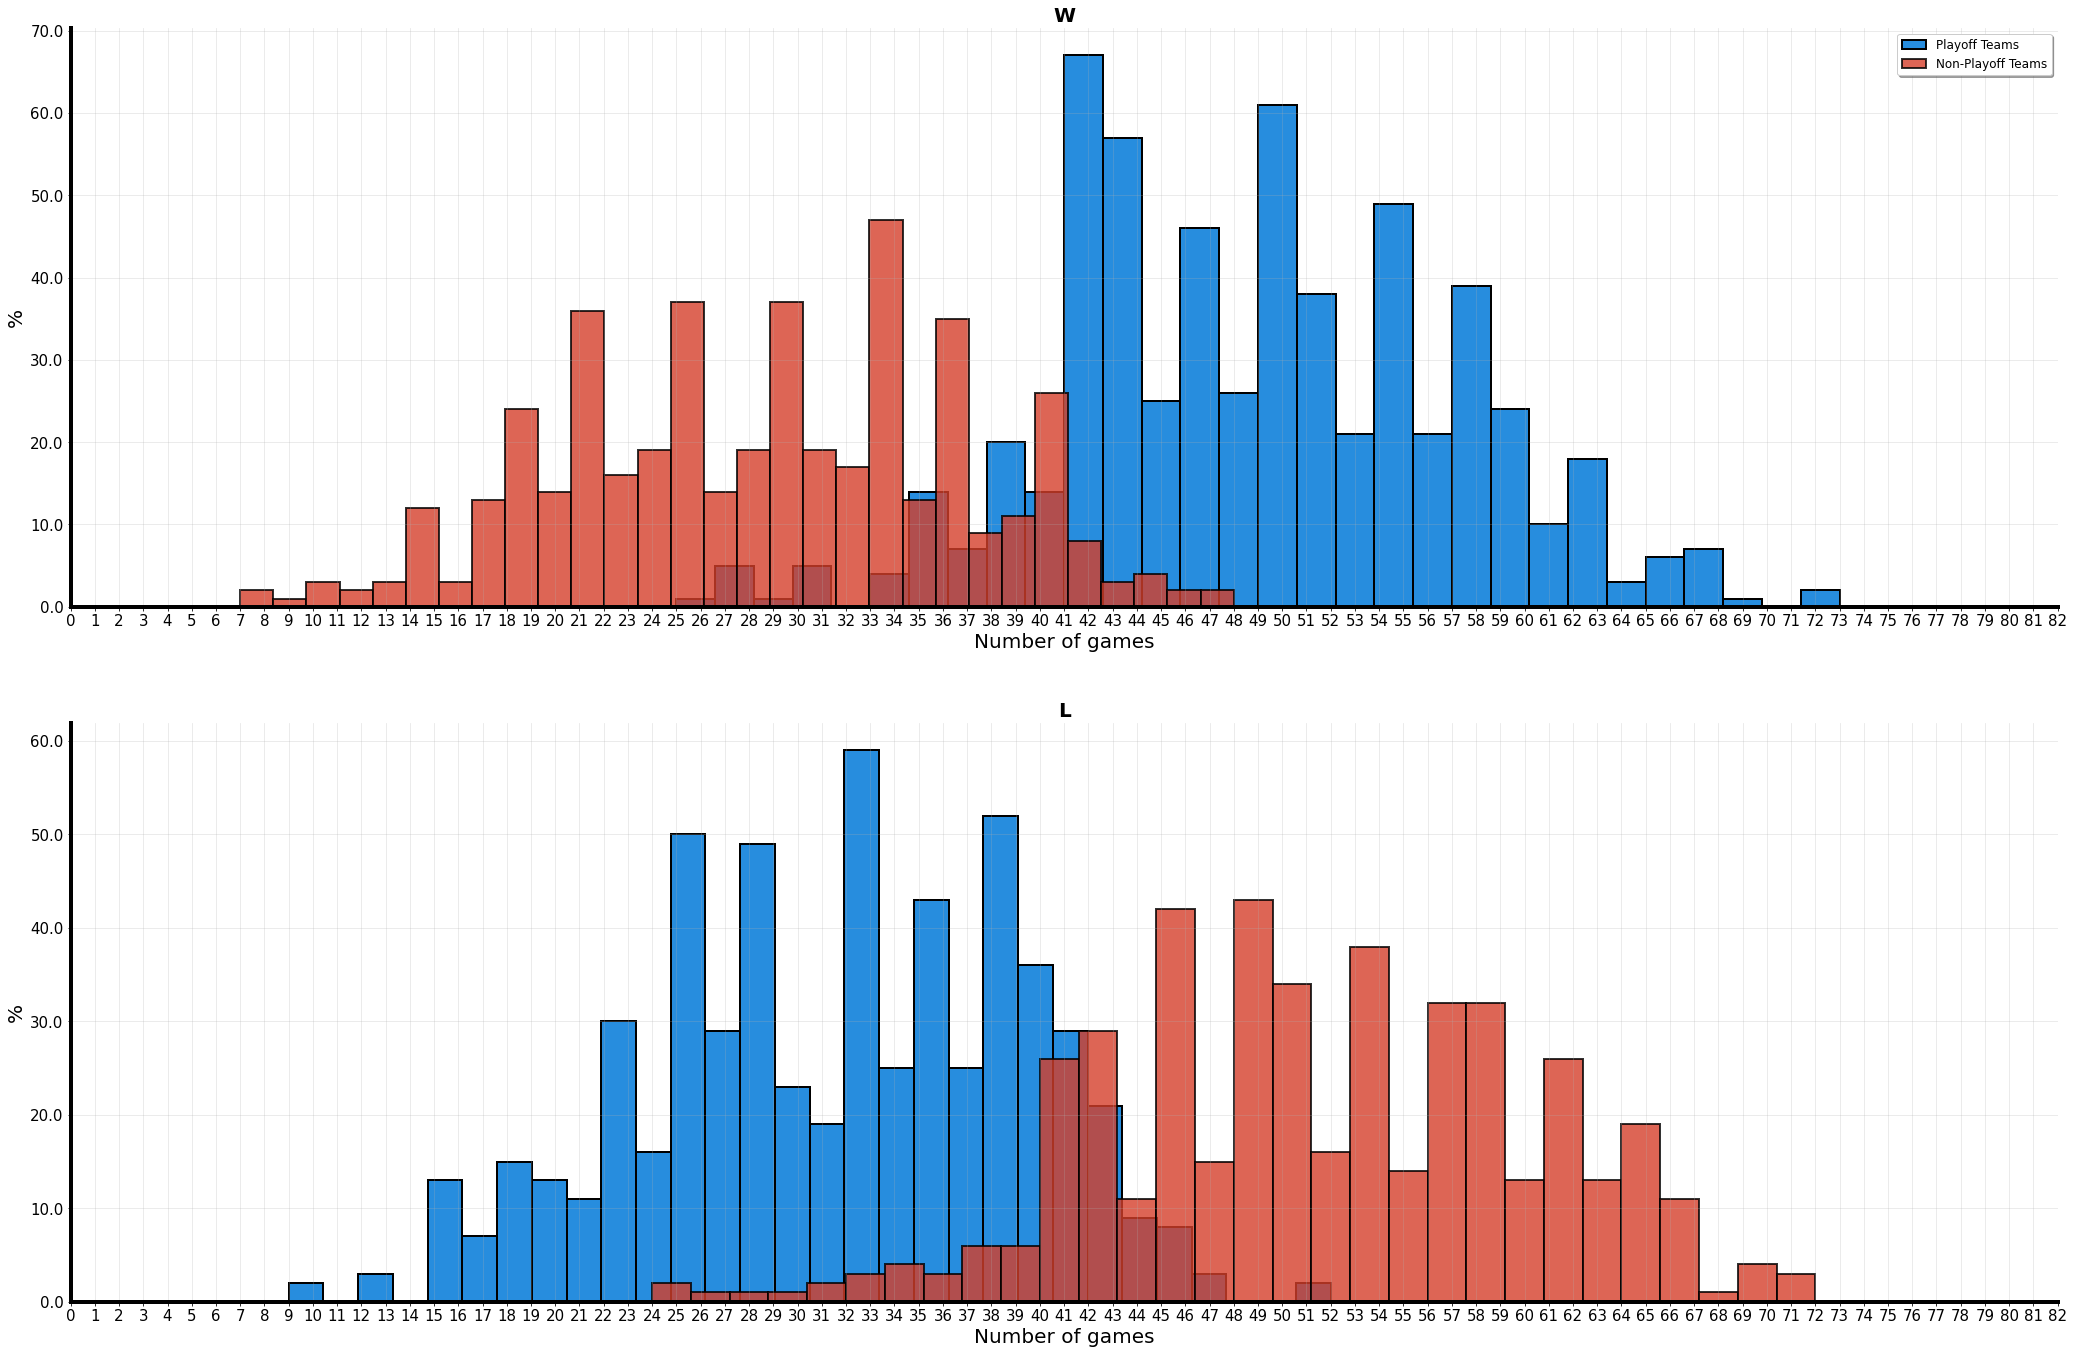

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(30,20))
cols = ["W", "L"]

for i, col in enumerate(cols):
    playoff_values = playoff_teams[col]
    non_playoff_values = non_playoff_teams[col]
    
    ax.flatten()[i].hist(playoff_values, bins=30, color=playoff_color, edgecolor='black', alpha=1, linewidth=2, label="Playoff Teams")
    ax.flatten()[i].hist(non_playoff_values, bins=30, color=non_playoff_color, edgecolor='black', alpha=0.8, linewidth=2, label="Non-Playoff Teams")
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)
    ax.flatten()[i].set_xlabel('Number of games', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
        
    
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.2 Offensive Stats

In [70]:
playoff_offense_stats=offense_stats[offense_stats["PLAYOFF"]==1]
playoff_offense_stats.reset_index(drop=True, inplace=True)

non_playoff_offense_stats=offense_stats[offense_stats["PLAYOFF"]==0]
non_playoff_offense_stats.reset_index(drop=True, inplace=True)

### 4.2.1 Points

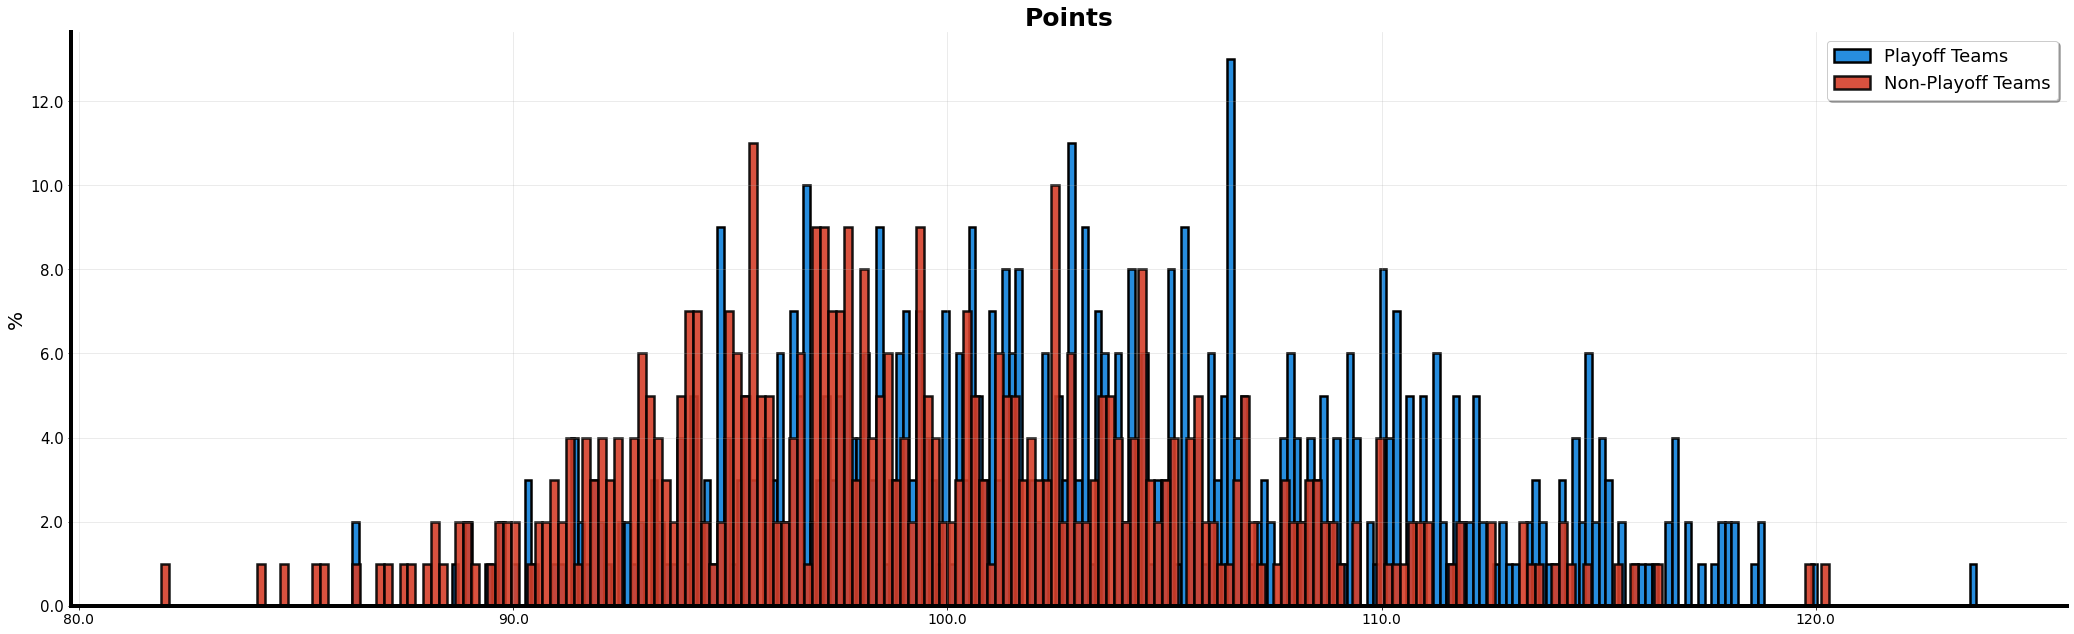

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))

playoff_points = playoff_offense_stats["PTS"]
playoff_bins = playoff_offense_stats["PTS"].value_counts().size

non_playoff_points = non_playoff_offense_stats["PTS"]
non_playoff_bins = non_playoff_offense_stats["PTS"].value_counts().size

ax.hist(playoff_points, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
ax.hist(non_playoff_points, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_title("Points", weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
# ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

# fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

### 4.2.2 Rebounds

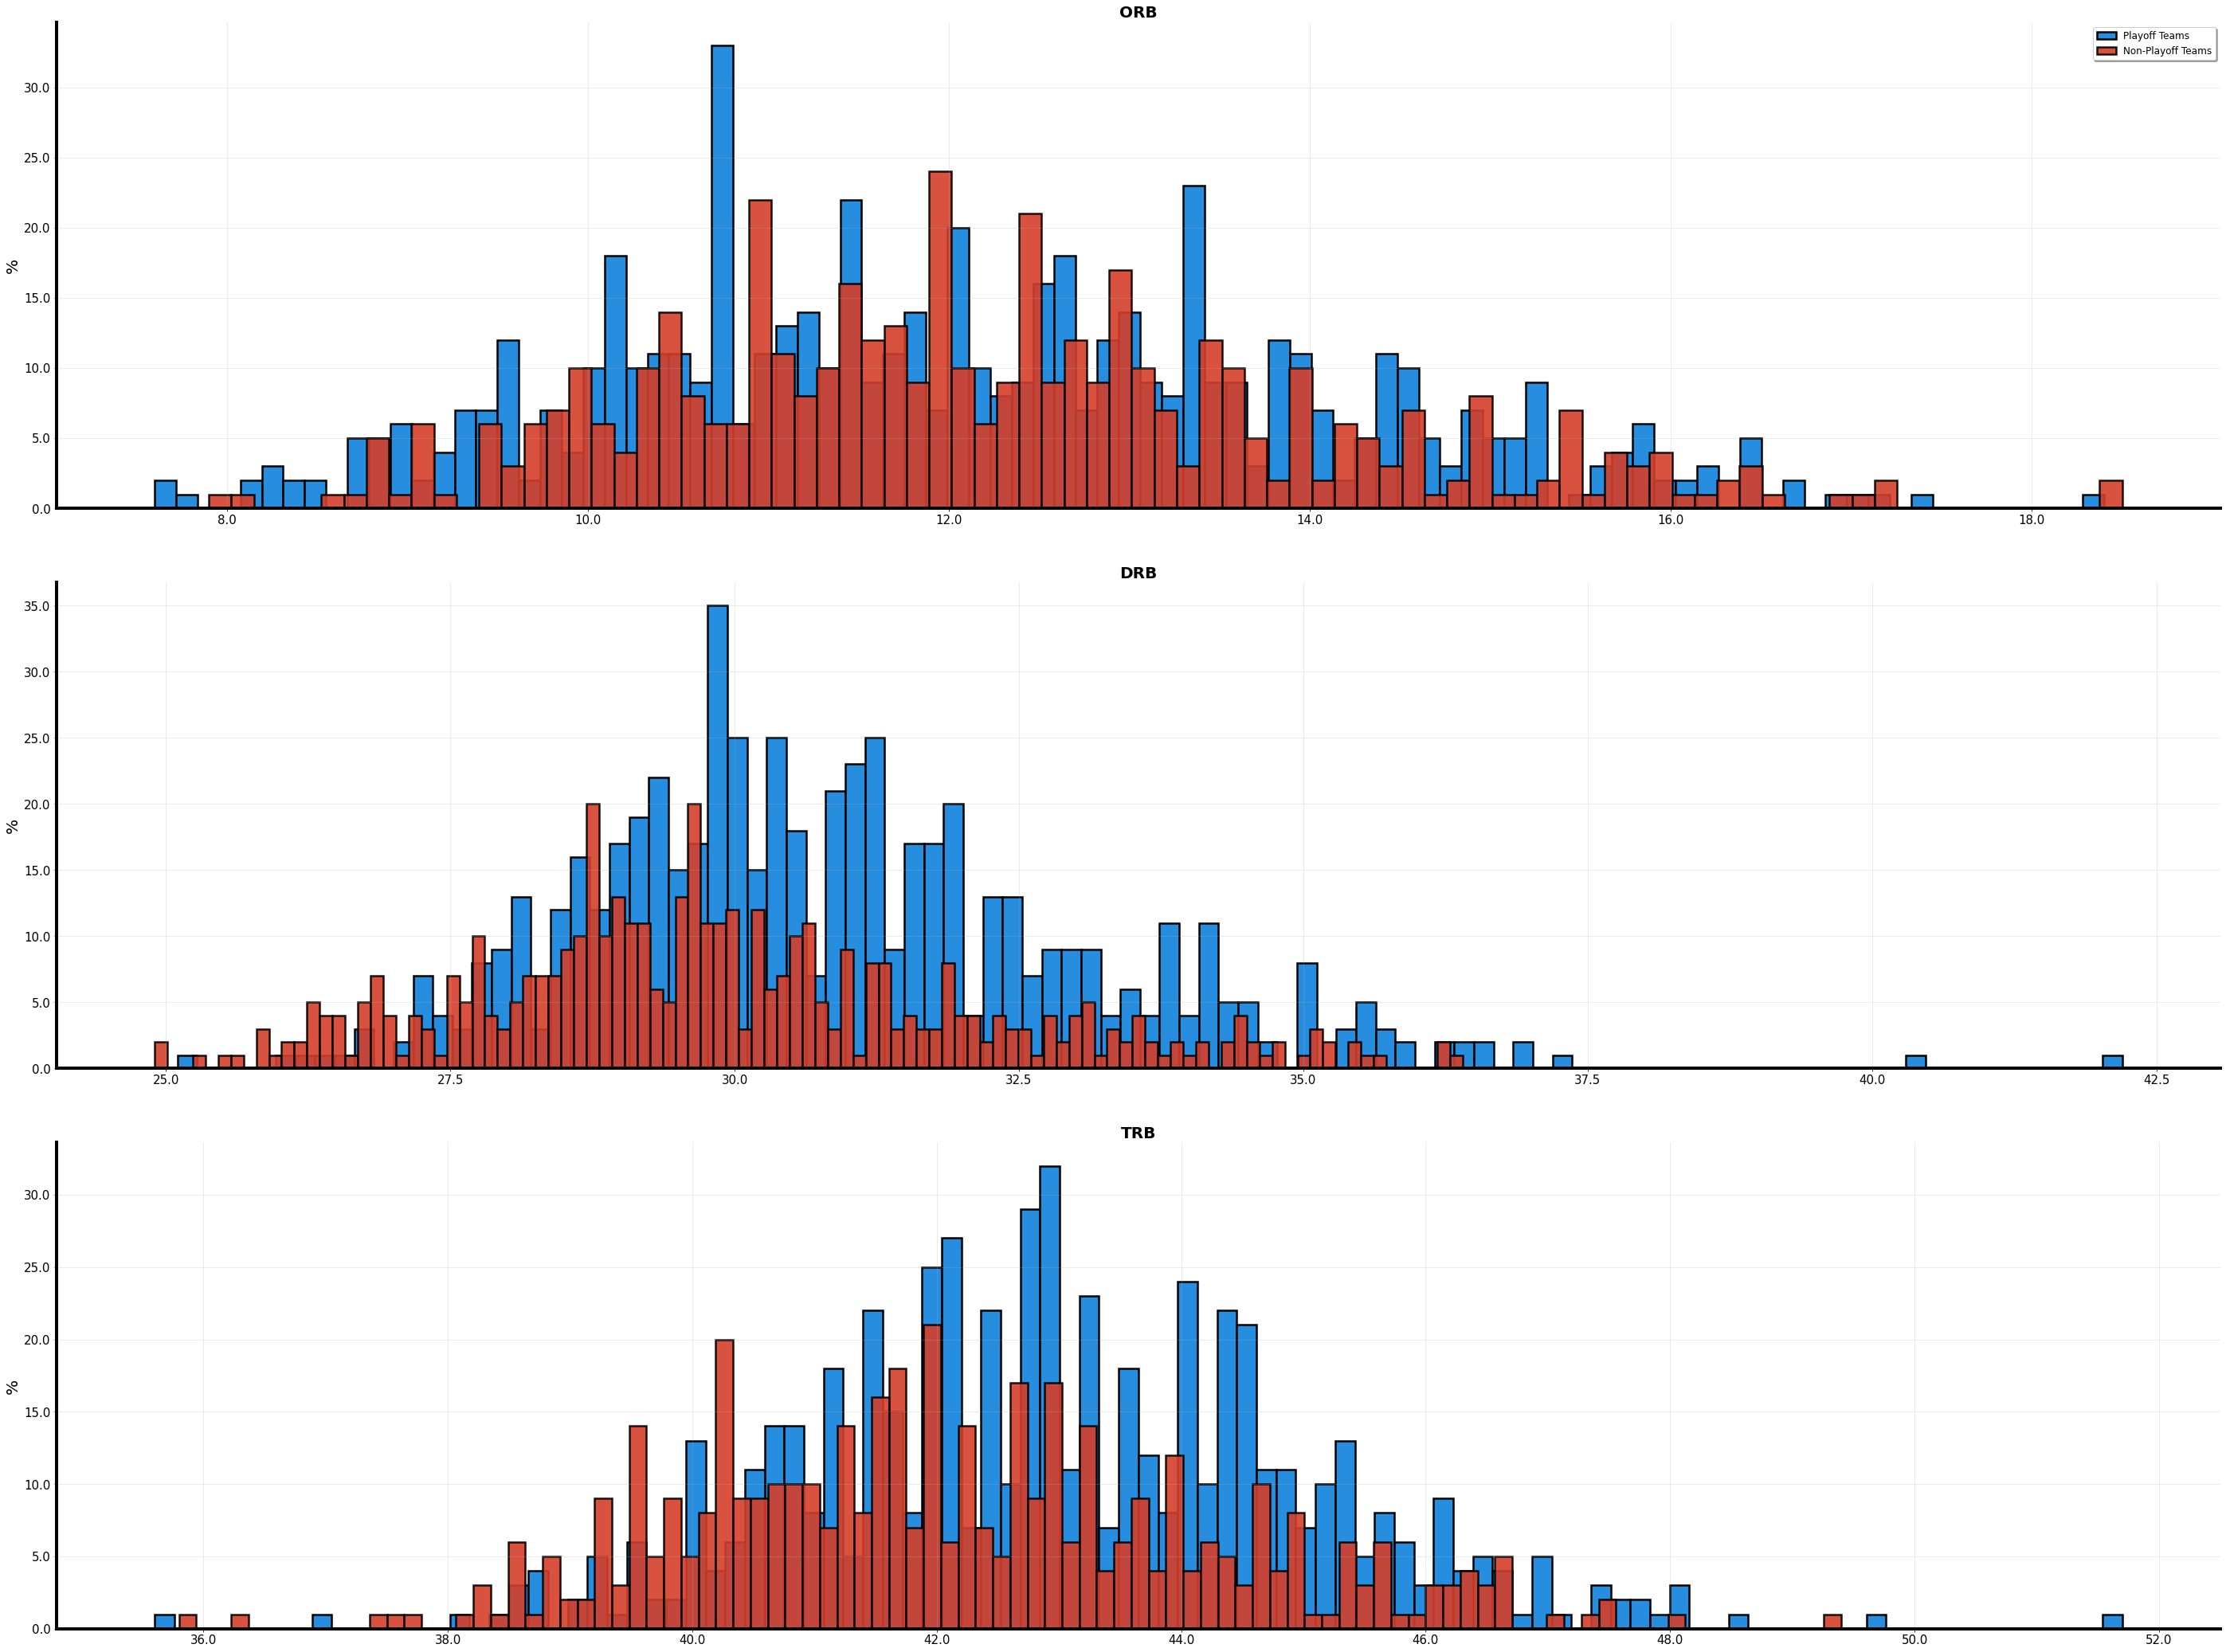

In [23]:
rebounds = ['ORB', 'DRB', 'TRB']


fig, ax = plt.subplots(3, 1, figsize=(40,30))

for i, col in enumerate(rebounds):
    
    playoff_rebounds = playoff_offense_stats[col]
    playoff_bins = playoff_offense_stats[col].value_counts().size

    non_playoff_rebounds = non_playoff_offense_stats[col]
    non_playoff_bins = non_playoff_offense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_rebounds, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_rebounds, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

### 4.2.3 Field Goal & Free Throw Percentage

In [24]:
# 'FG','FGA','3P','3PA','2P','2PA', 'FT', 'FTA',

attempts = ['FGA', '3PA', '2PA', 'FTA']
percentage = ['2P%','3P%','FG%', 'FT%']

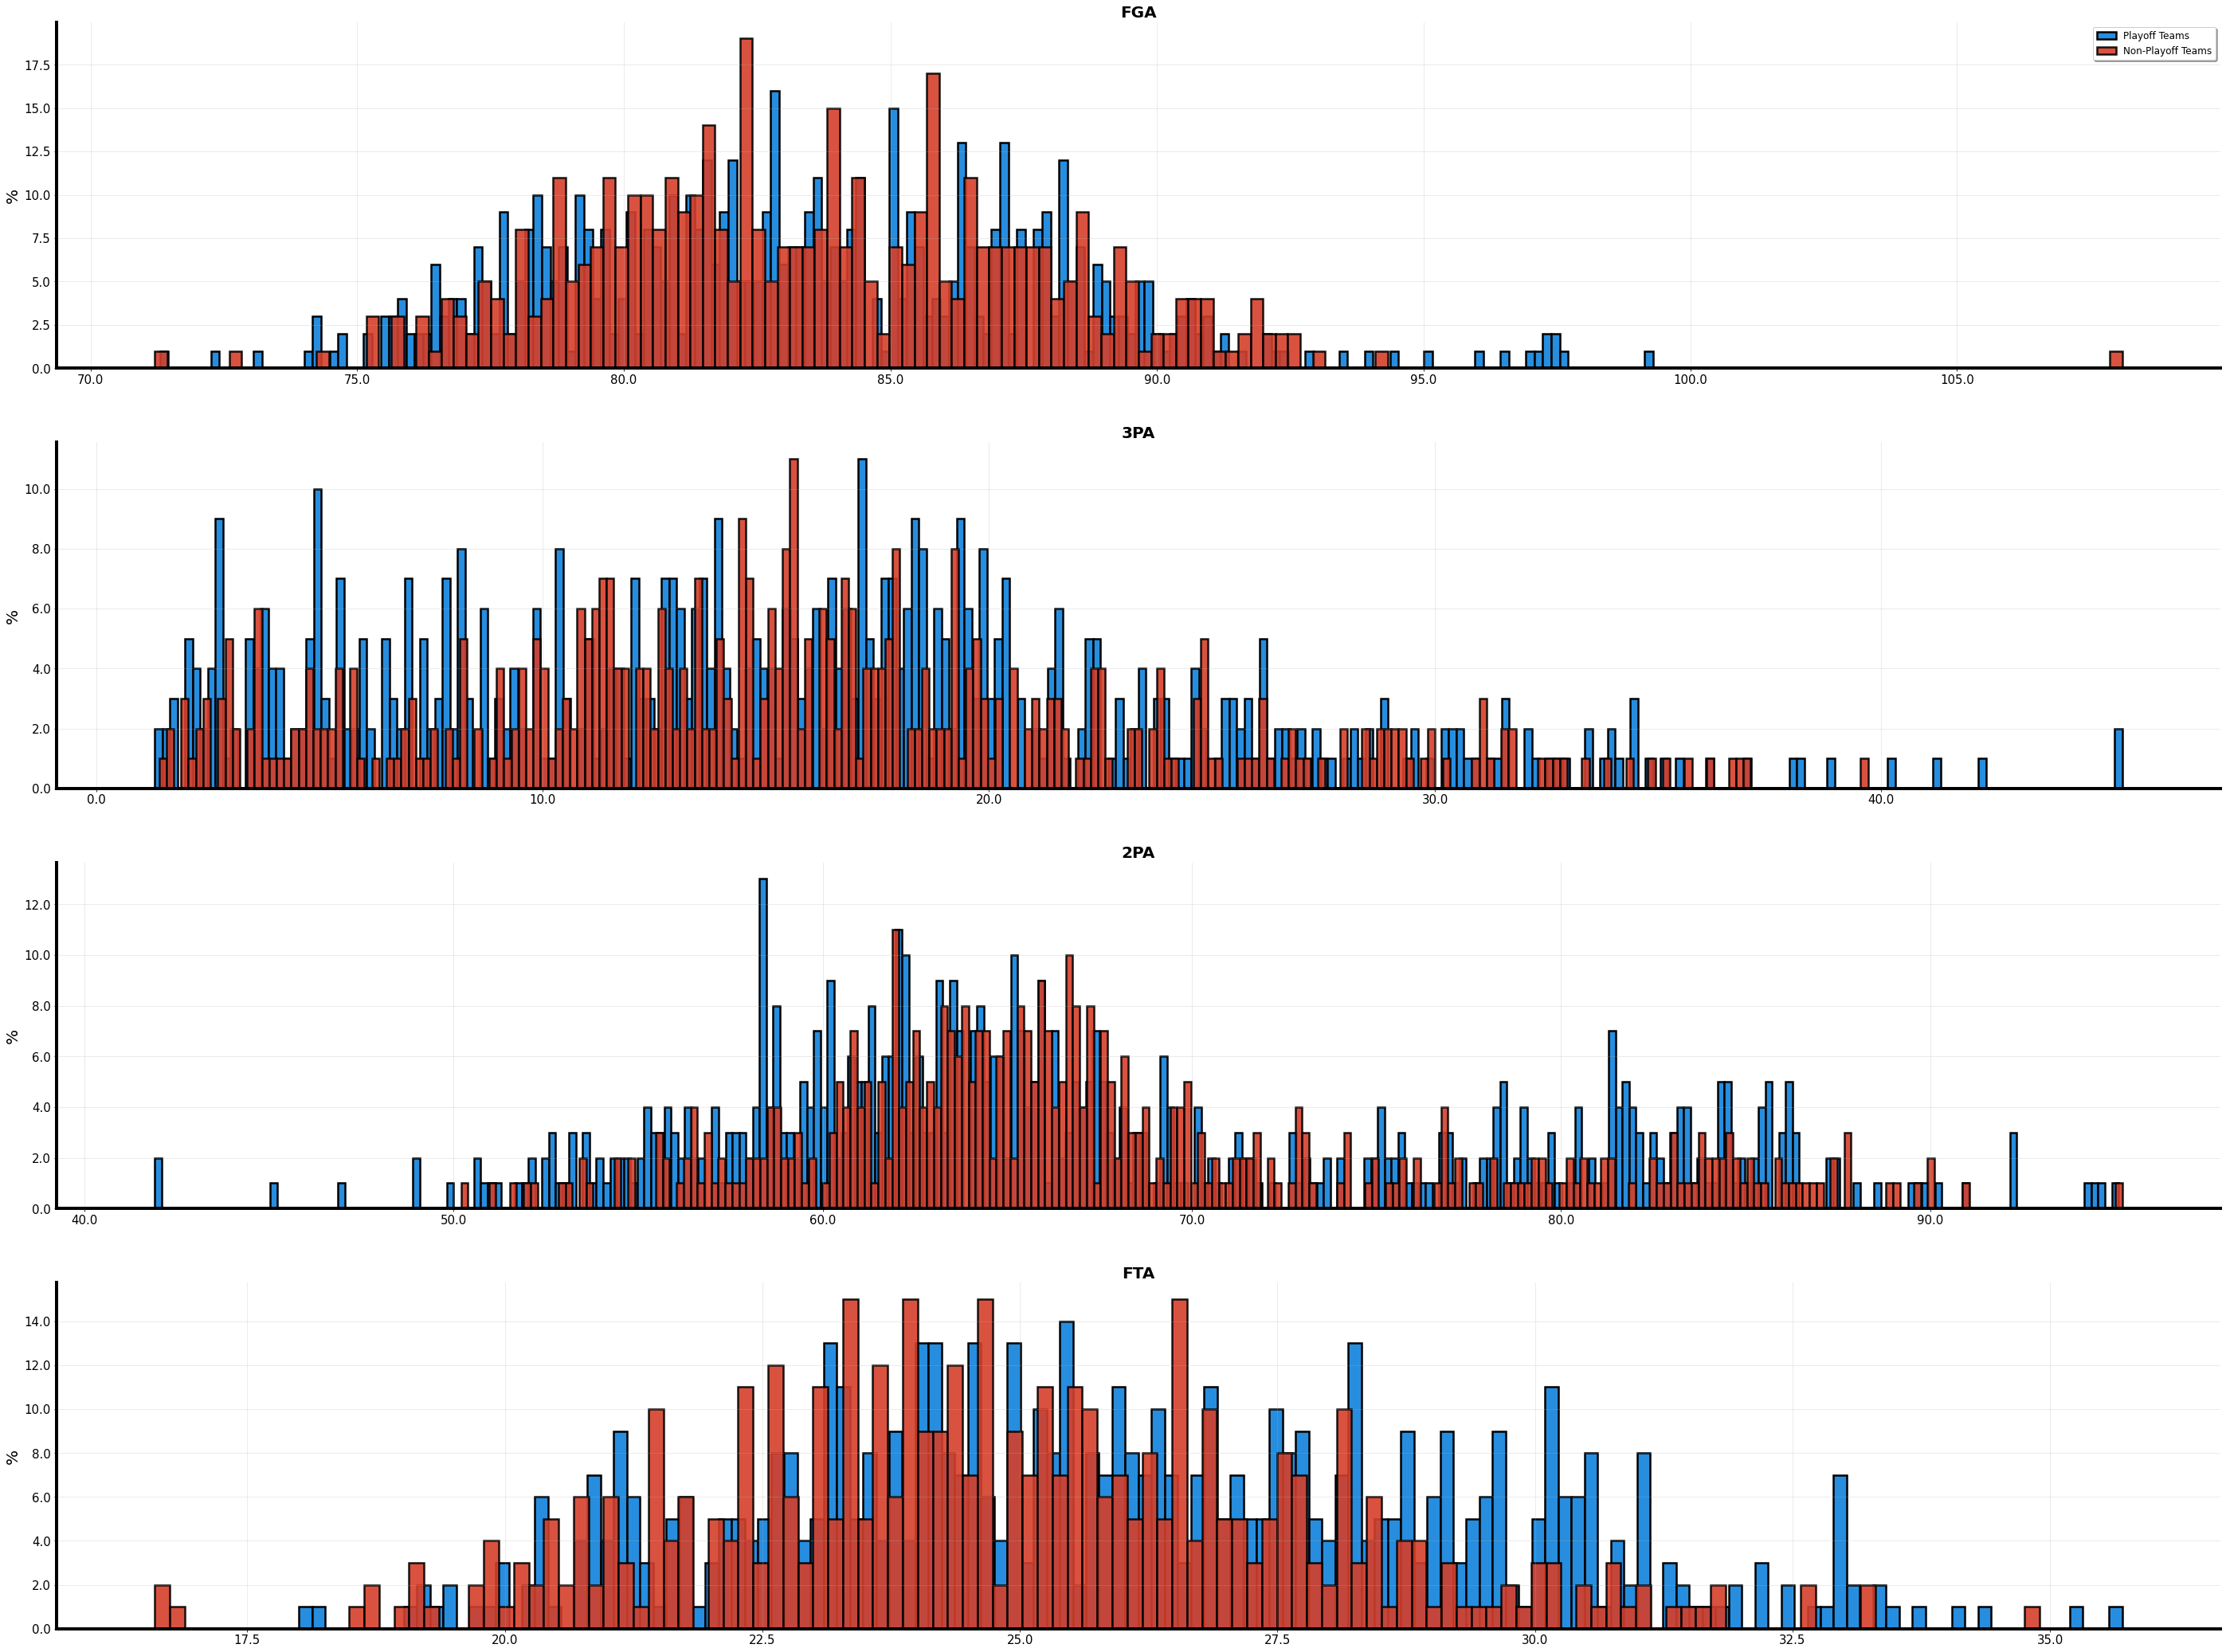

In [25]:

fig, ax = plt.subplots(4, 1, figsize=(40,30))

for i, col in enumerate(attempts):
    
    playoff_percentage = playoff_offense_stats[col]
    playoff_bins = playoff_offense_stats[col].value_counts().size

    non_playoff_percentage = non_playoff_offense_stats[col]
    non_playoff_bins = non_playoff_offense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_percentage, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_percentage, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

### 4.2.4 Others

In [26]:
others = ['AST', 'STL','BLK', 'TOV', 'PF']

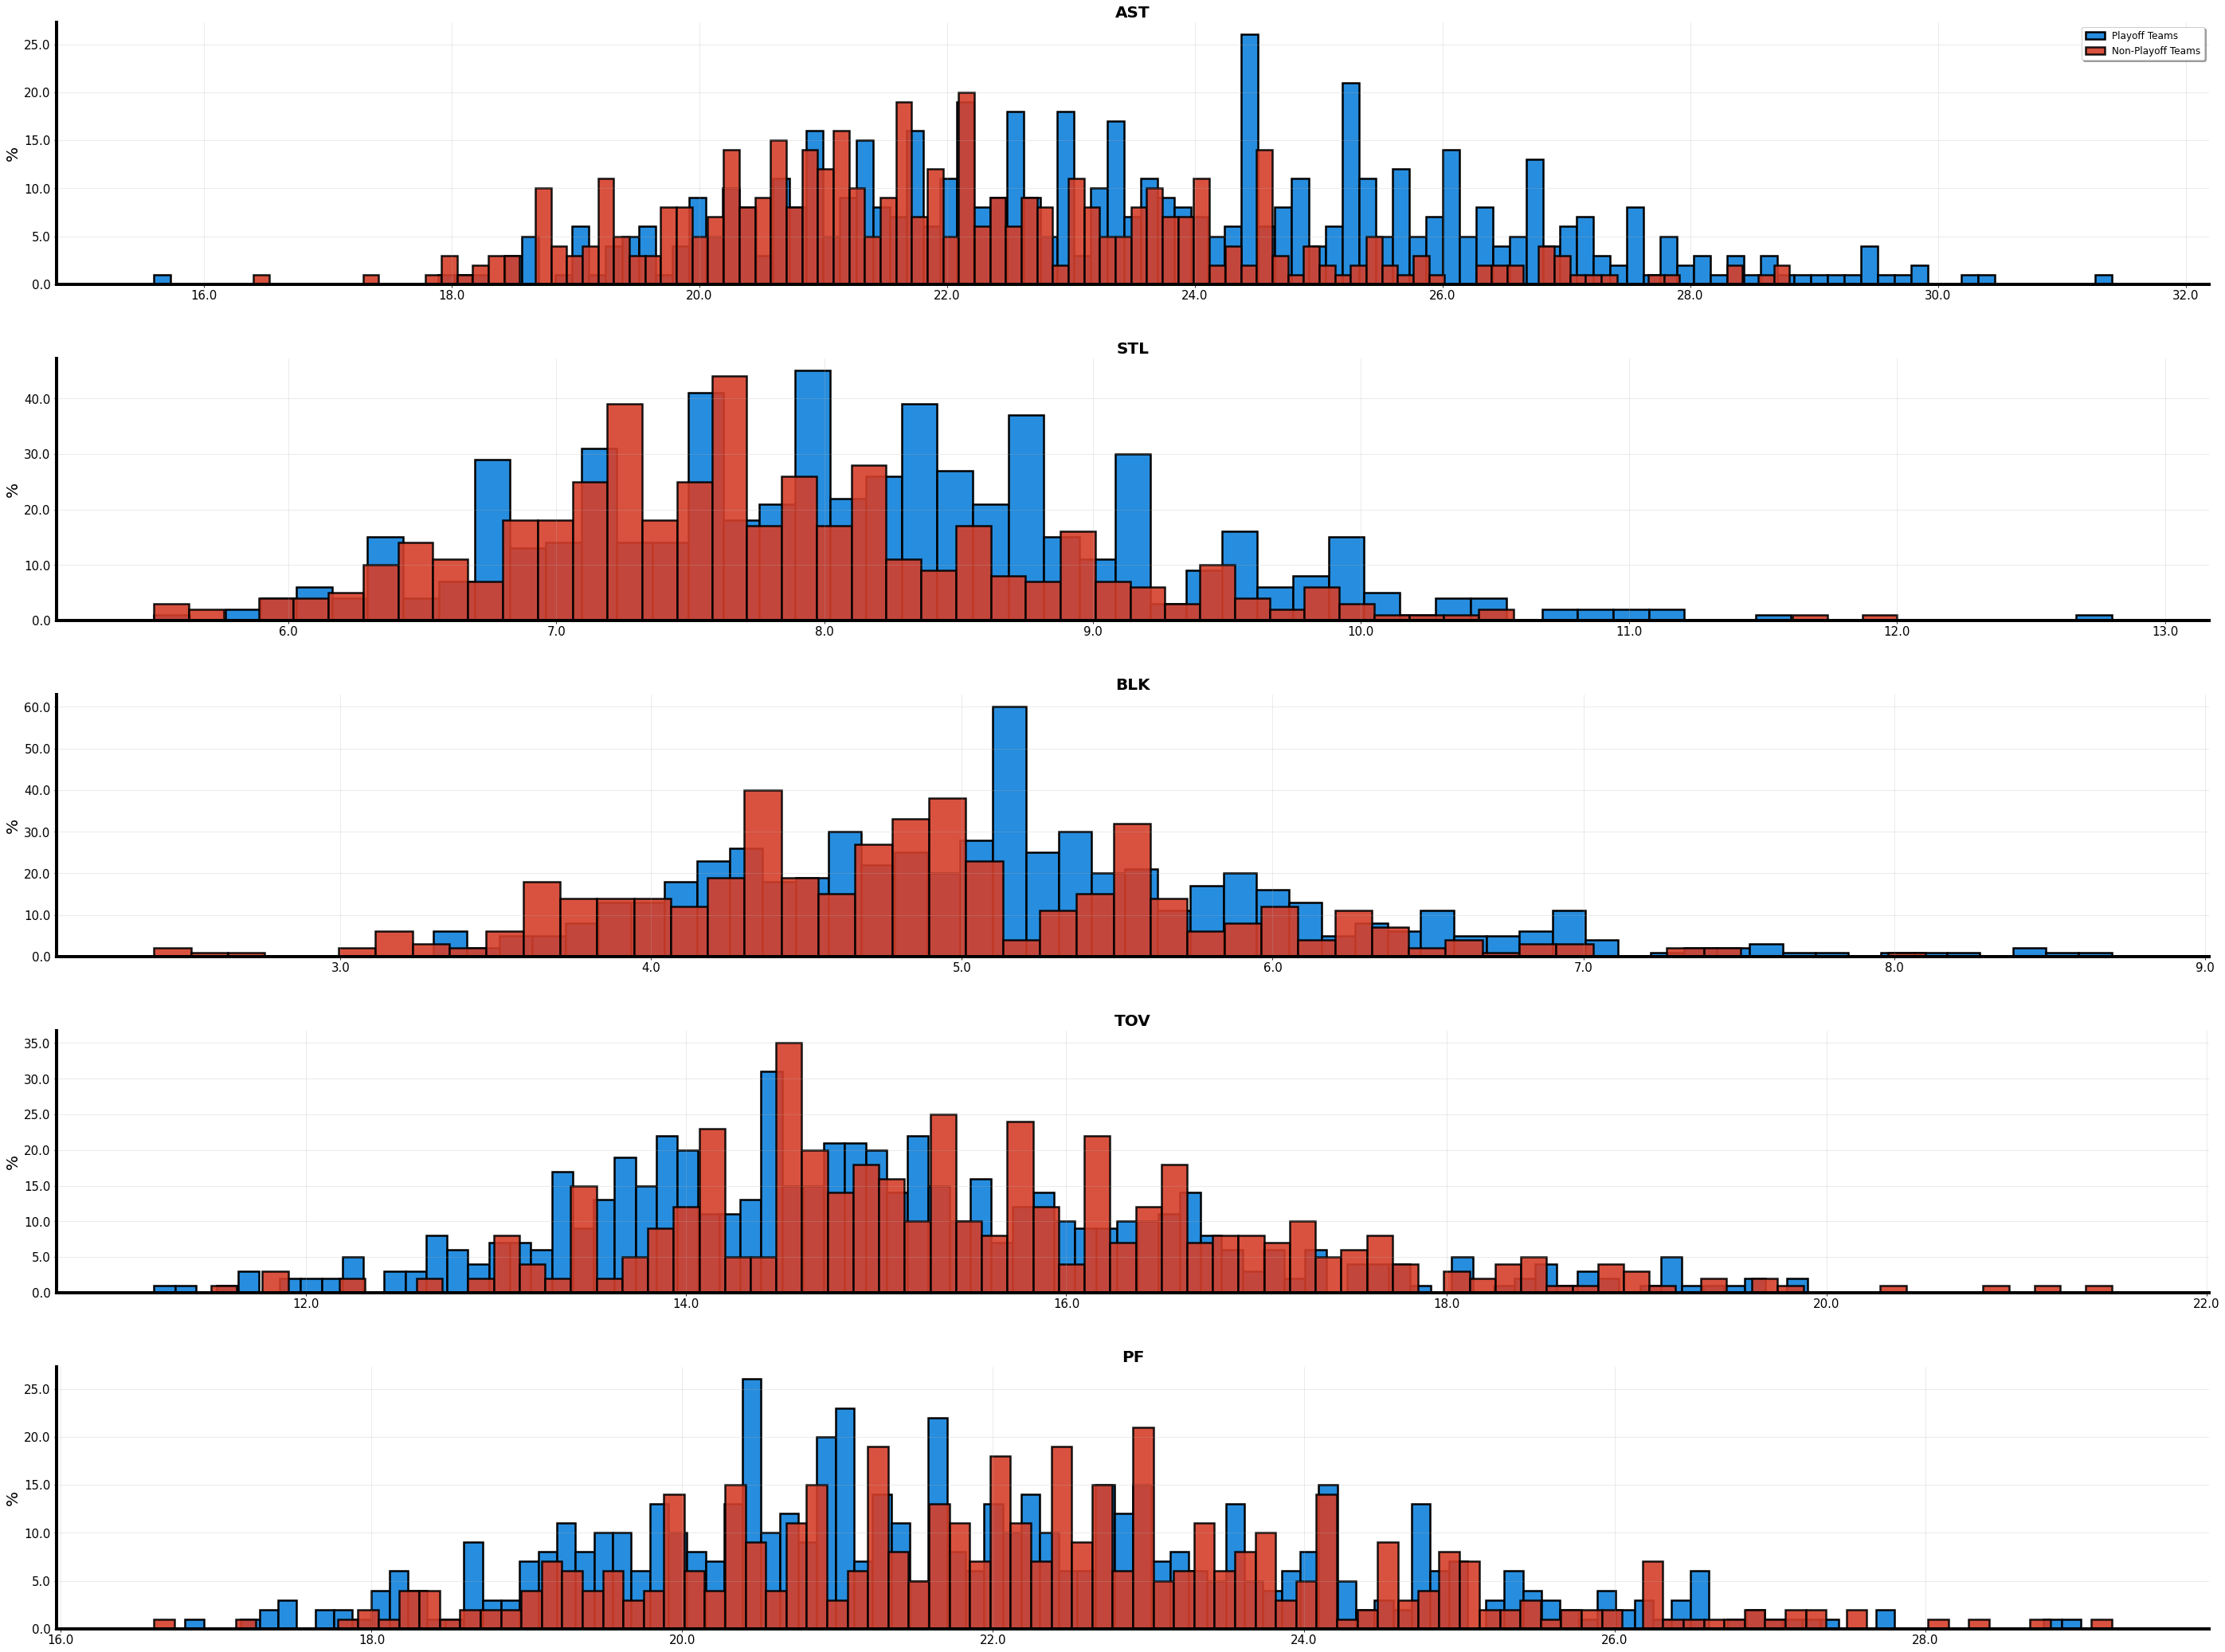

In [27]:
fig, ax = plt.subplots(5, 1, figsize=(40,30))

for i, col in enumerate(others):
    
    playoff_stats = playoff_offense_stats[col]
    playoff_bins = playoff_offense_stats[col].value_counts().size

    non_playoff_stats = non_playoff_offense_stats[col]
    non_playoff_bins = non_playoff_offense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_stats, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_stats, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.3 Defensive Stats

In [28]:
playoff_defense_stats=defense_stats[defense_stats["PLAYOFF"]==1]
playoff_defense_stats.reset_index(drop=True, inplace=True)

non_playoff_defense_stats=defense_stats[defense_stats["PLAYOFF"]==0]
non_playoff_defense_stats.reset_index(drop=True, inplace=True)

### 4.3.1 Points

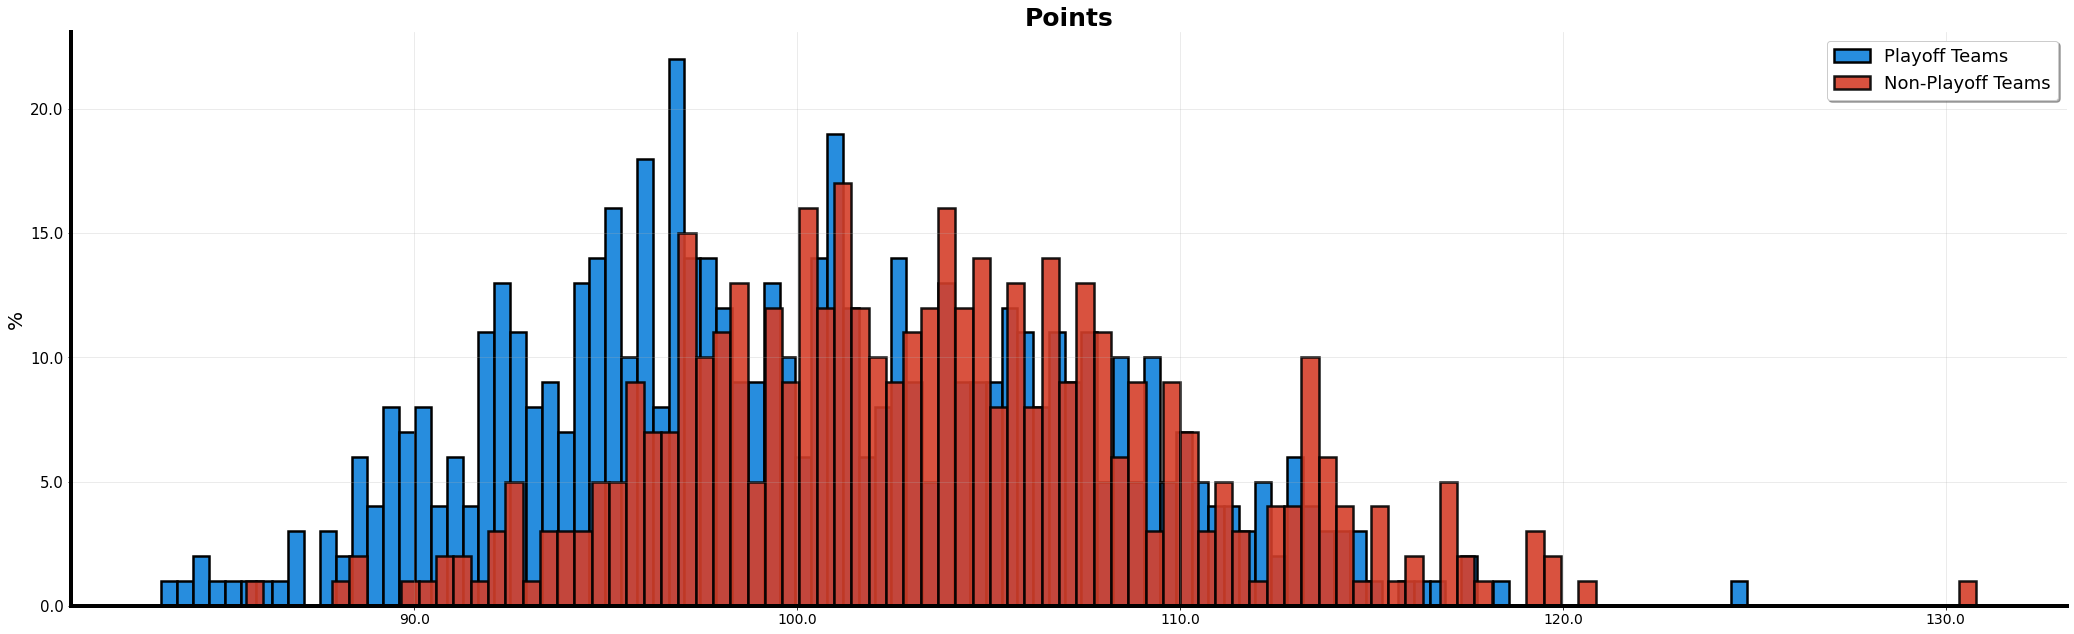

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))

playoff_points = playoff_defense_stats["PTS"]
playoff_bins = playoff_defense_stats["PTS"].value_counts().size

non_playoff_points = non_playoff_defense_stats["PTS"]
non_playoff_bins = non_playoff_defense_stats["PTS"].value_counts().size

ax.hist(playoff_points, bins=100, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
ax.hist(non_playoff_points, bins=100, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_title("Points", weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
# ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

# fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

### 4.3.2 Rebounds

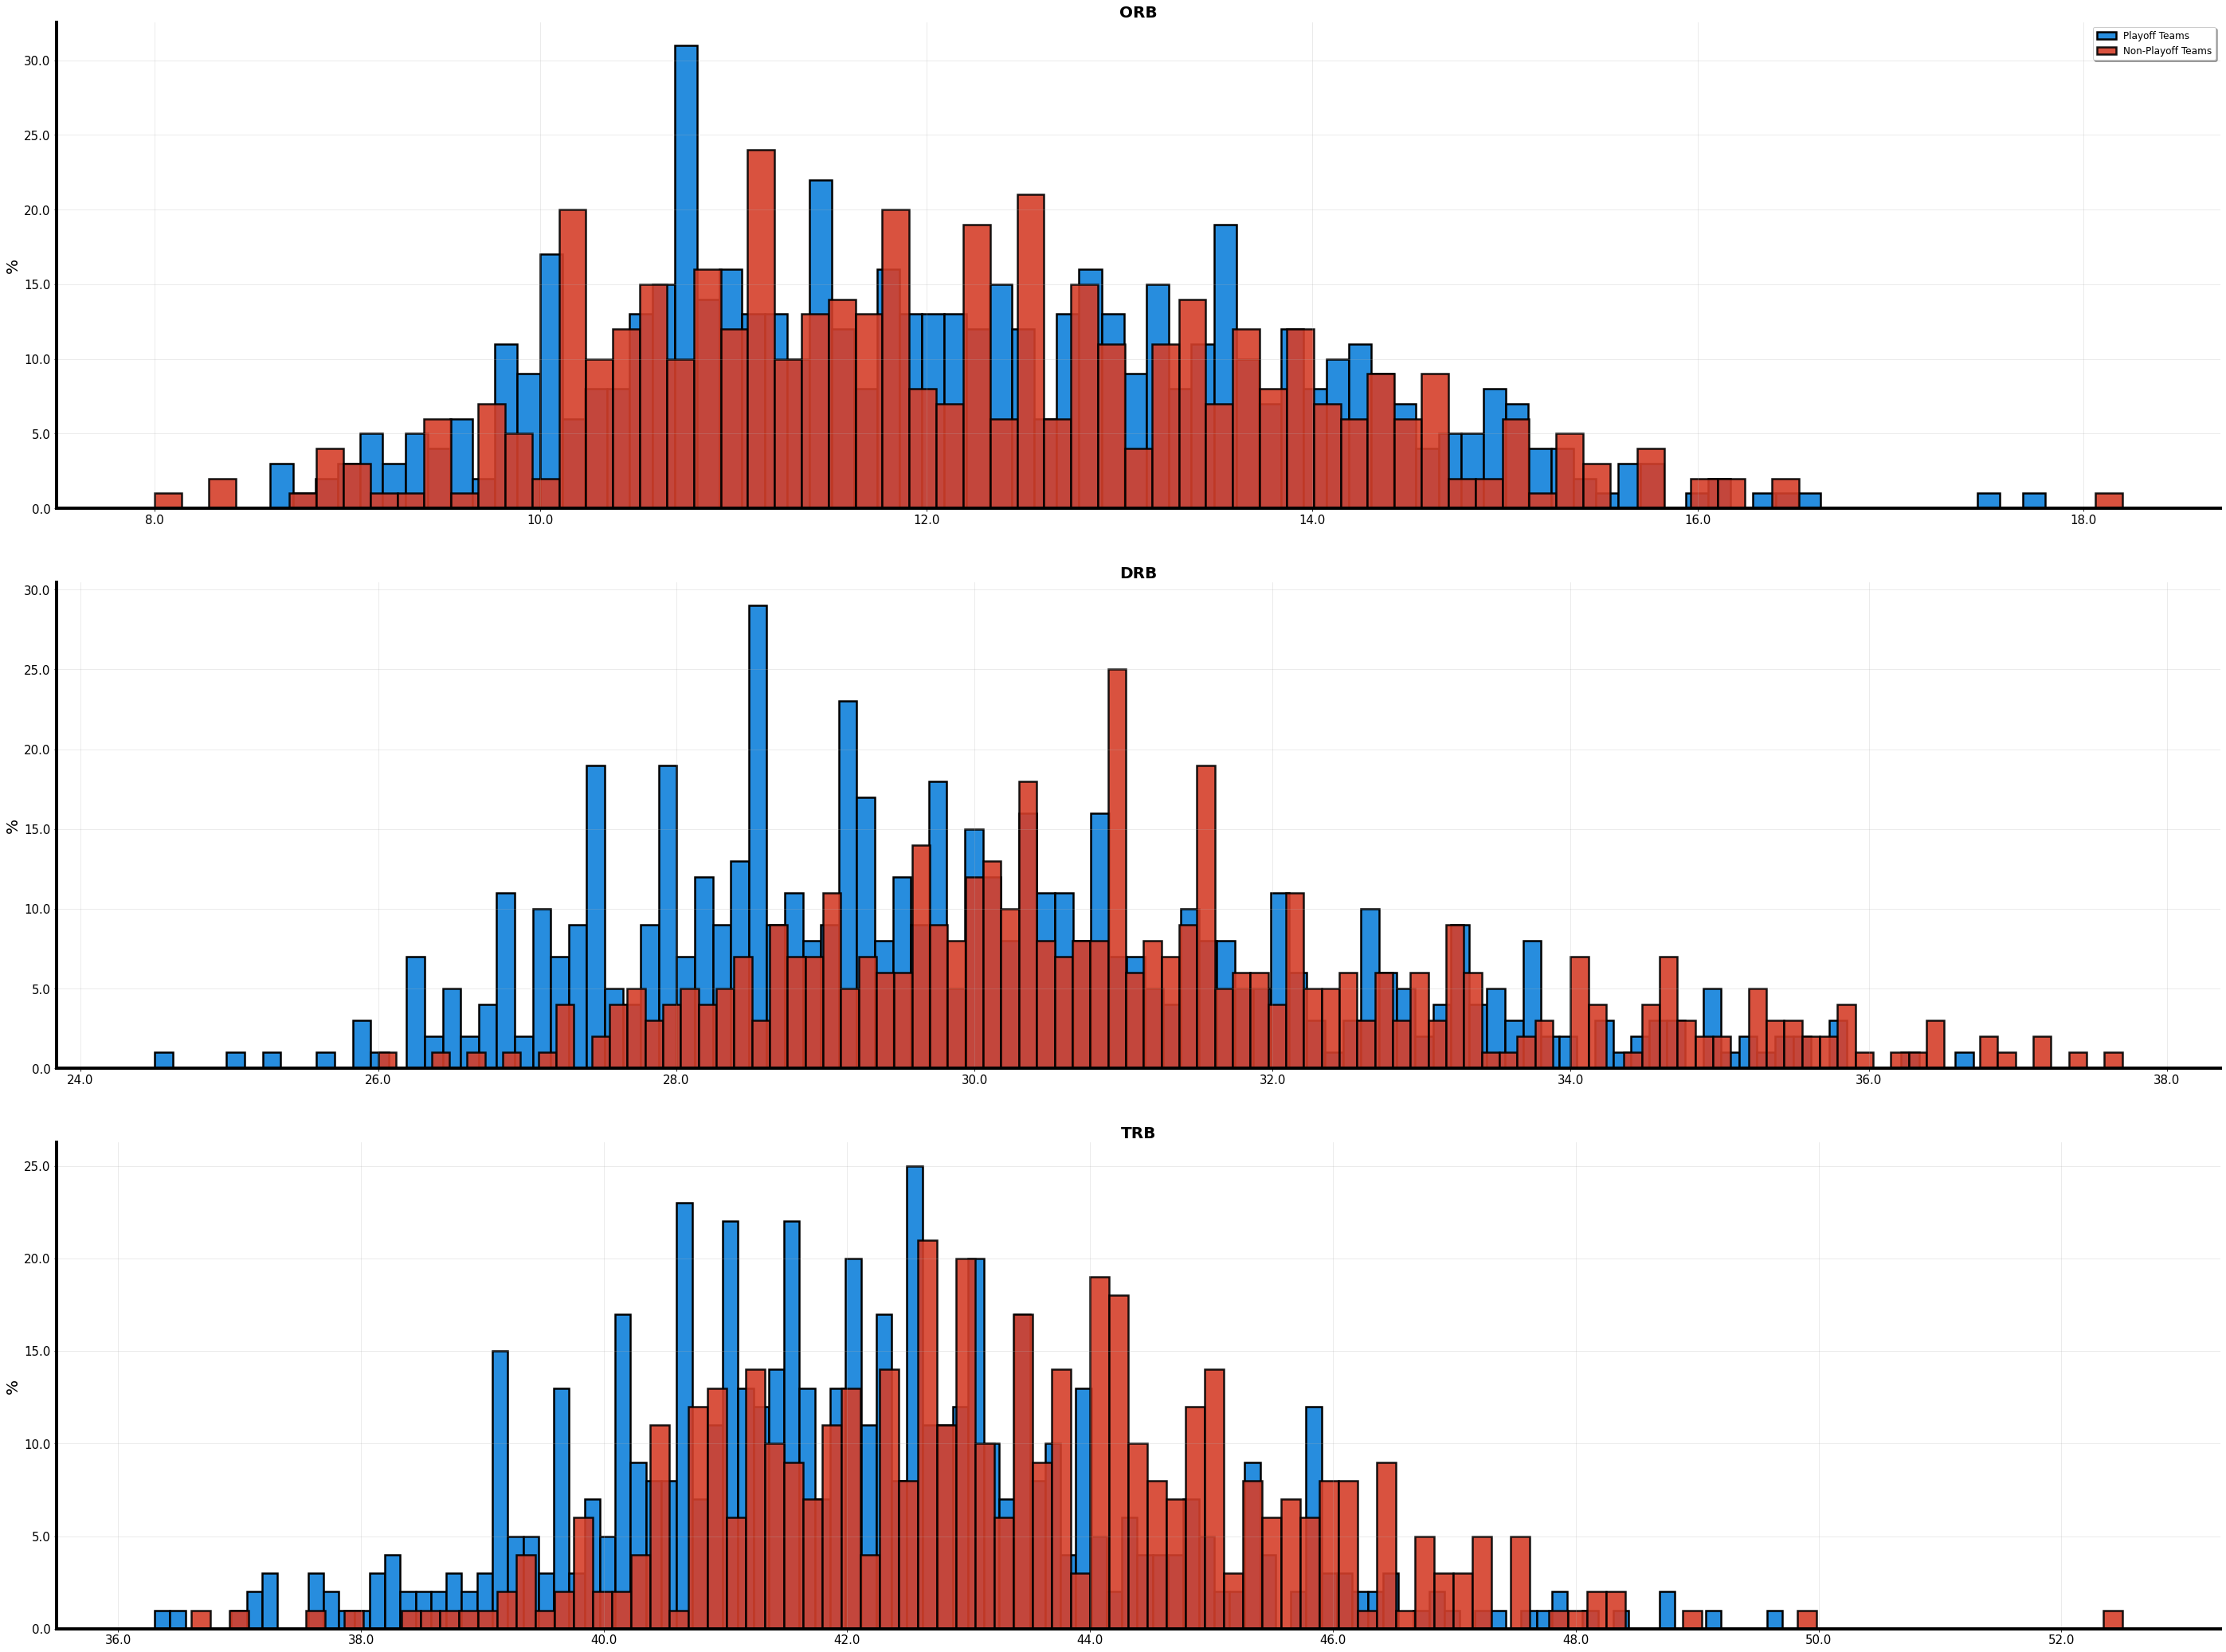

In [30]:

rebounds = ['ORB', 'DRB', 'TRB']


fig, ax = plt.subplots(3, 1, figsize=(40,30))

for i, col in enumerate(rebounds):
    
    playoff_rebounds = playoff_defense_stats[col]
    playoff_bins = playoff_defense_stats[col].value_counts().size

    non_playoff_rebounds = non_playoff_defense_stats[col]
    non_playoff_bins = non_playoff_defense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_rebounds, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_rebounds, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

### 4.3.3 Field Goal & Free Throw Percentage

In [31]:
# 'FG','FGA','3P','3PA','2P','2PA', 'FT', 'FTA',

attempts = ['FGA', '3PA', '2PA', 'FTA']
percentage = ['2P%','3P%','FG%', 'FT%']

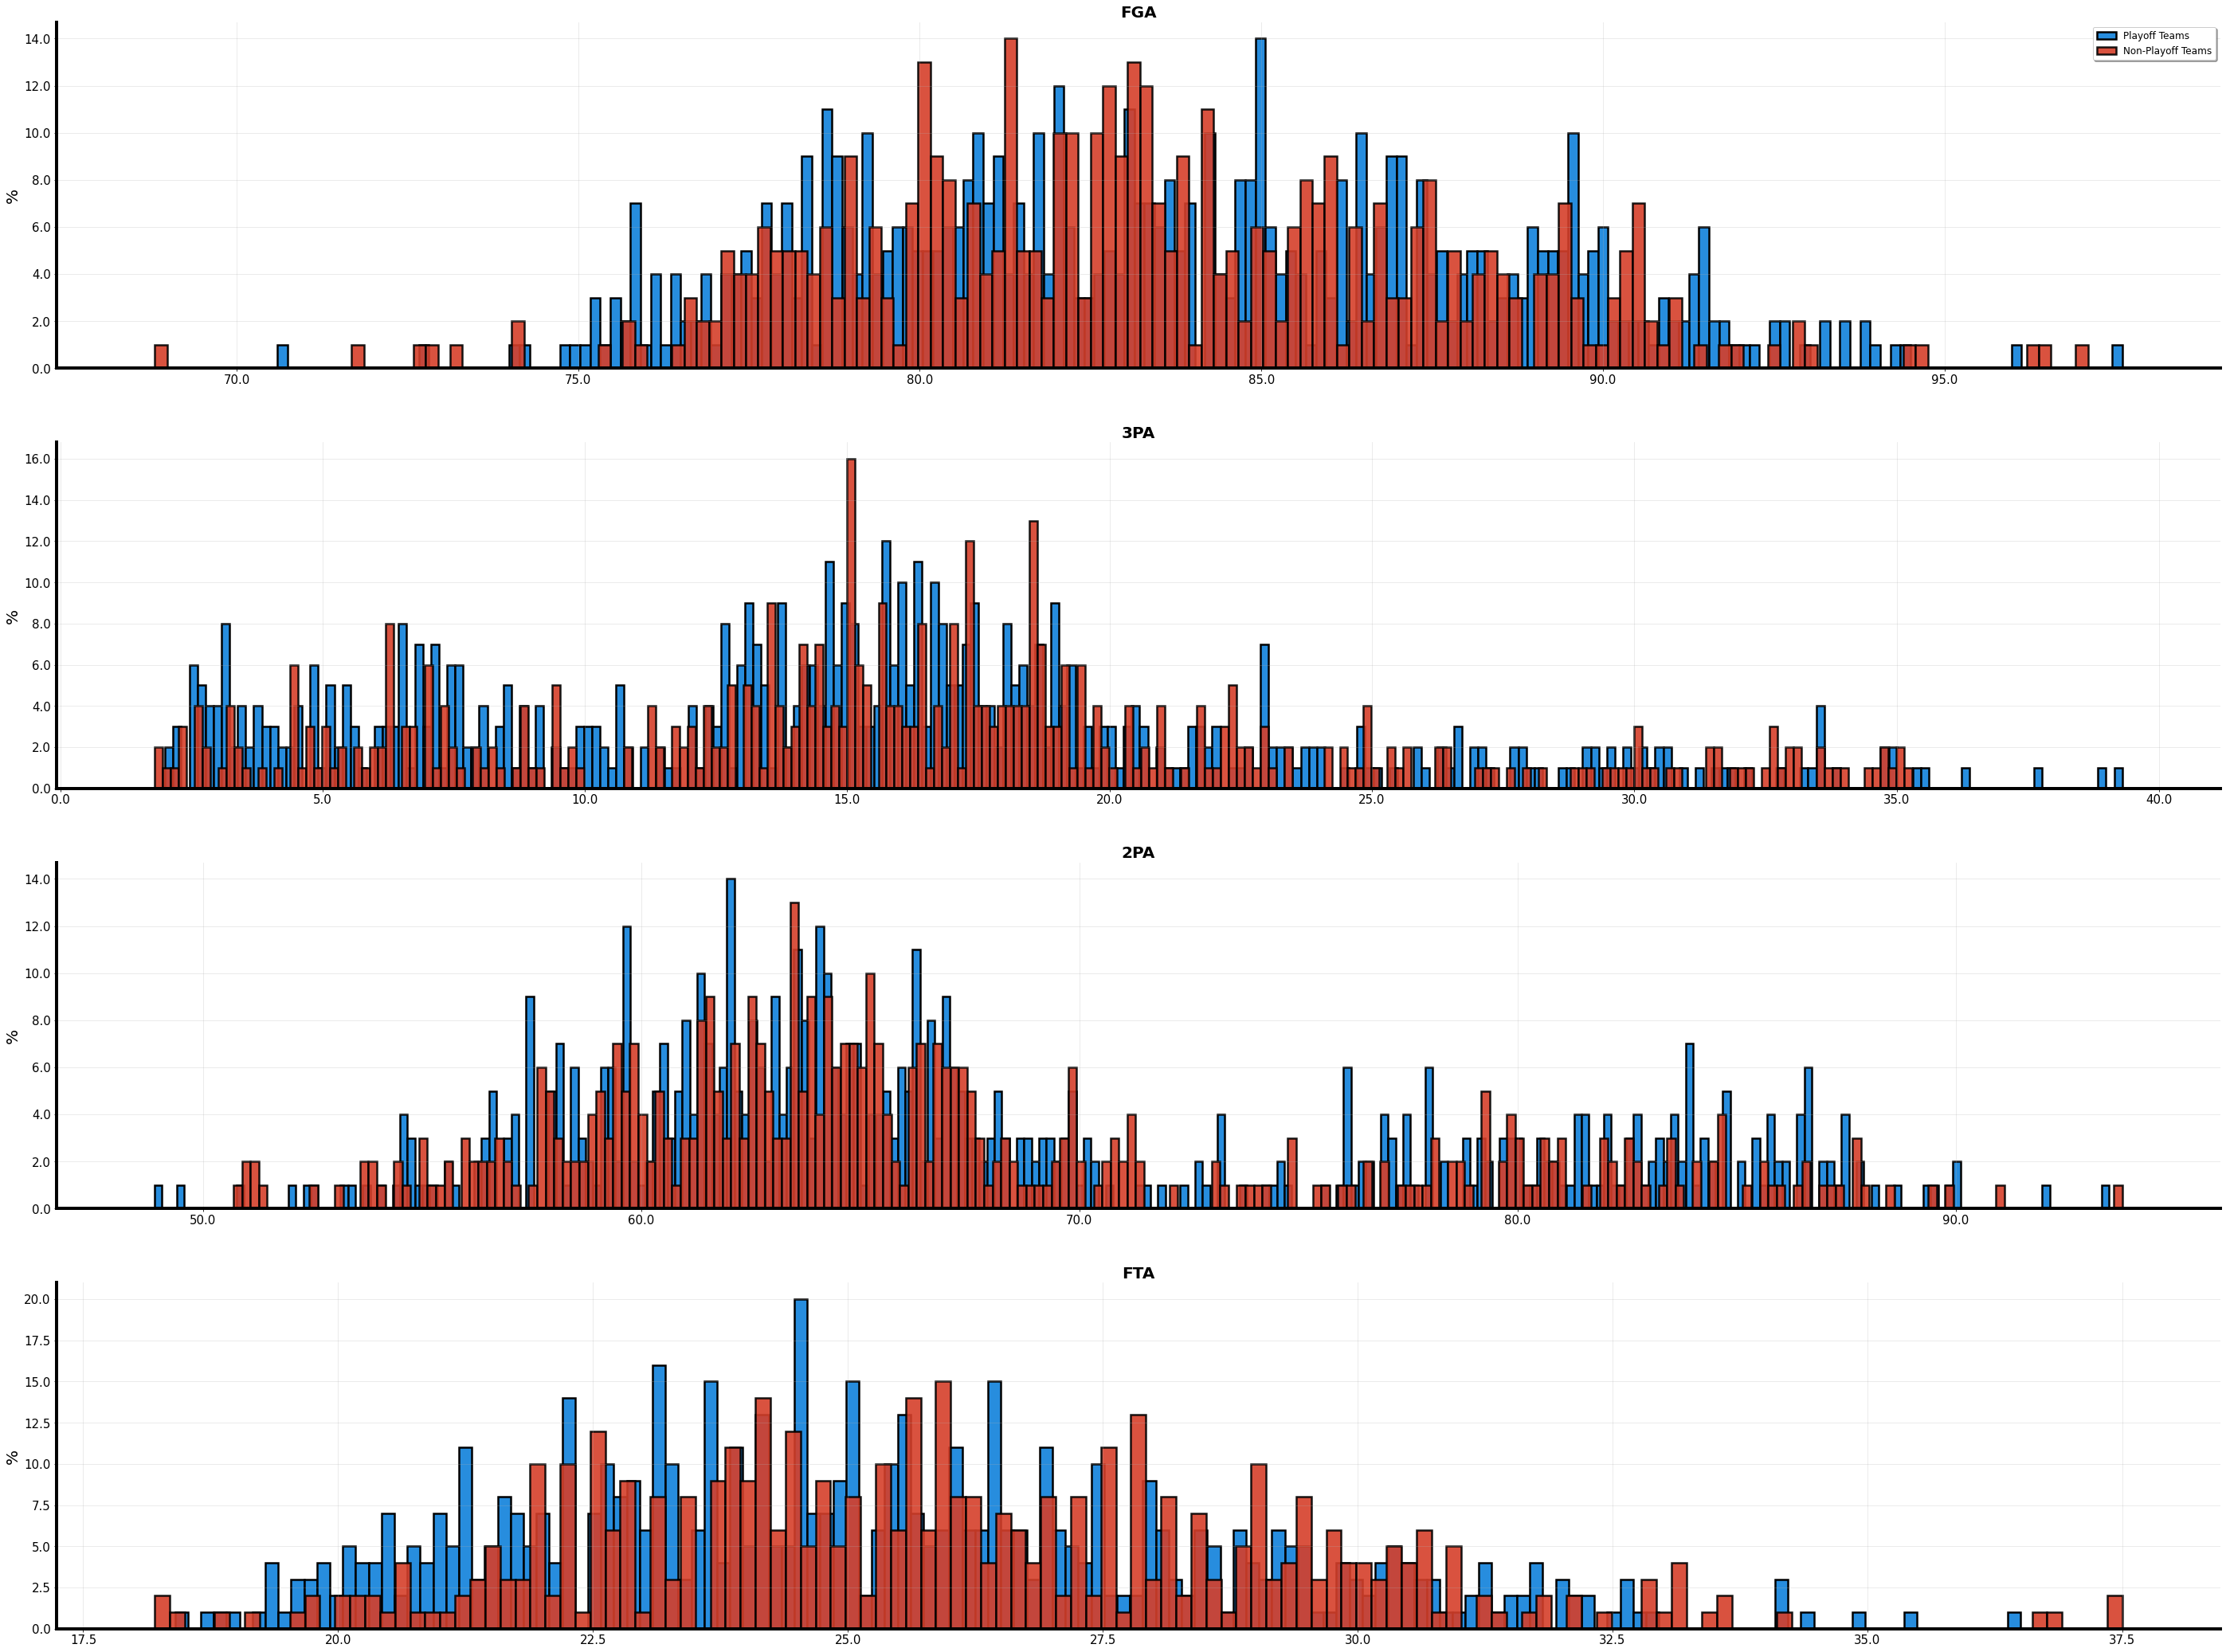

In [32]:
# playoff_defense_stats
# non_playoff_defense_stats

fig, ax = plt.subplots(4, 1, figsize=(40,30))

for i, col in enumerate(attempts):
    
    playoff_percentage = playoff_defense_stats[col]
    playoff_bins = playoff_defense_stats[col].value_counts().size

    non_playoff_percentage = non_playoff_defense_stats[col]
    non_playoff_bins = non_playoff_defense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_percentage, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_percentage, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

### 4.3.4 Others

In [33]:
others = ['AST', 'STL','BLK', 'TOV', 'PF']

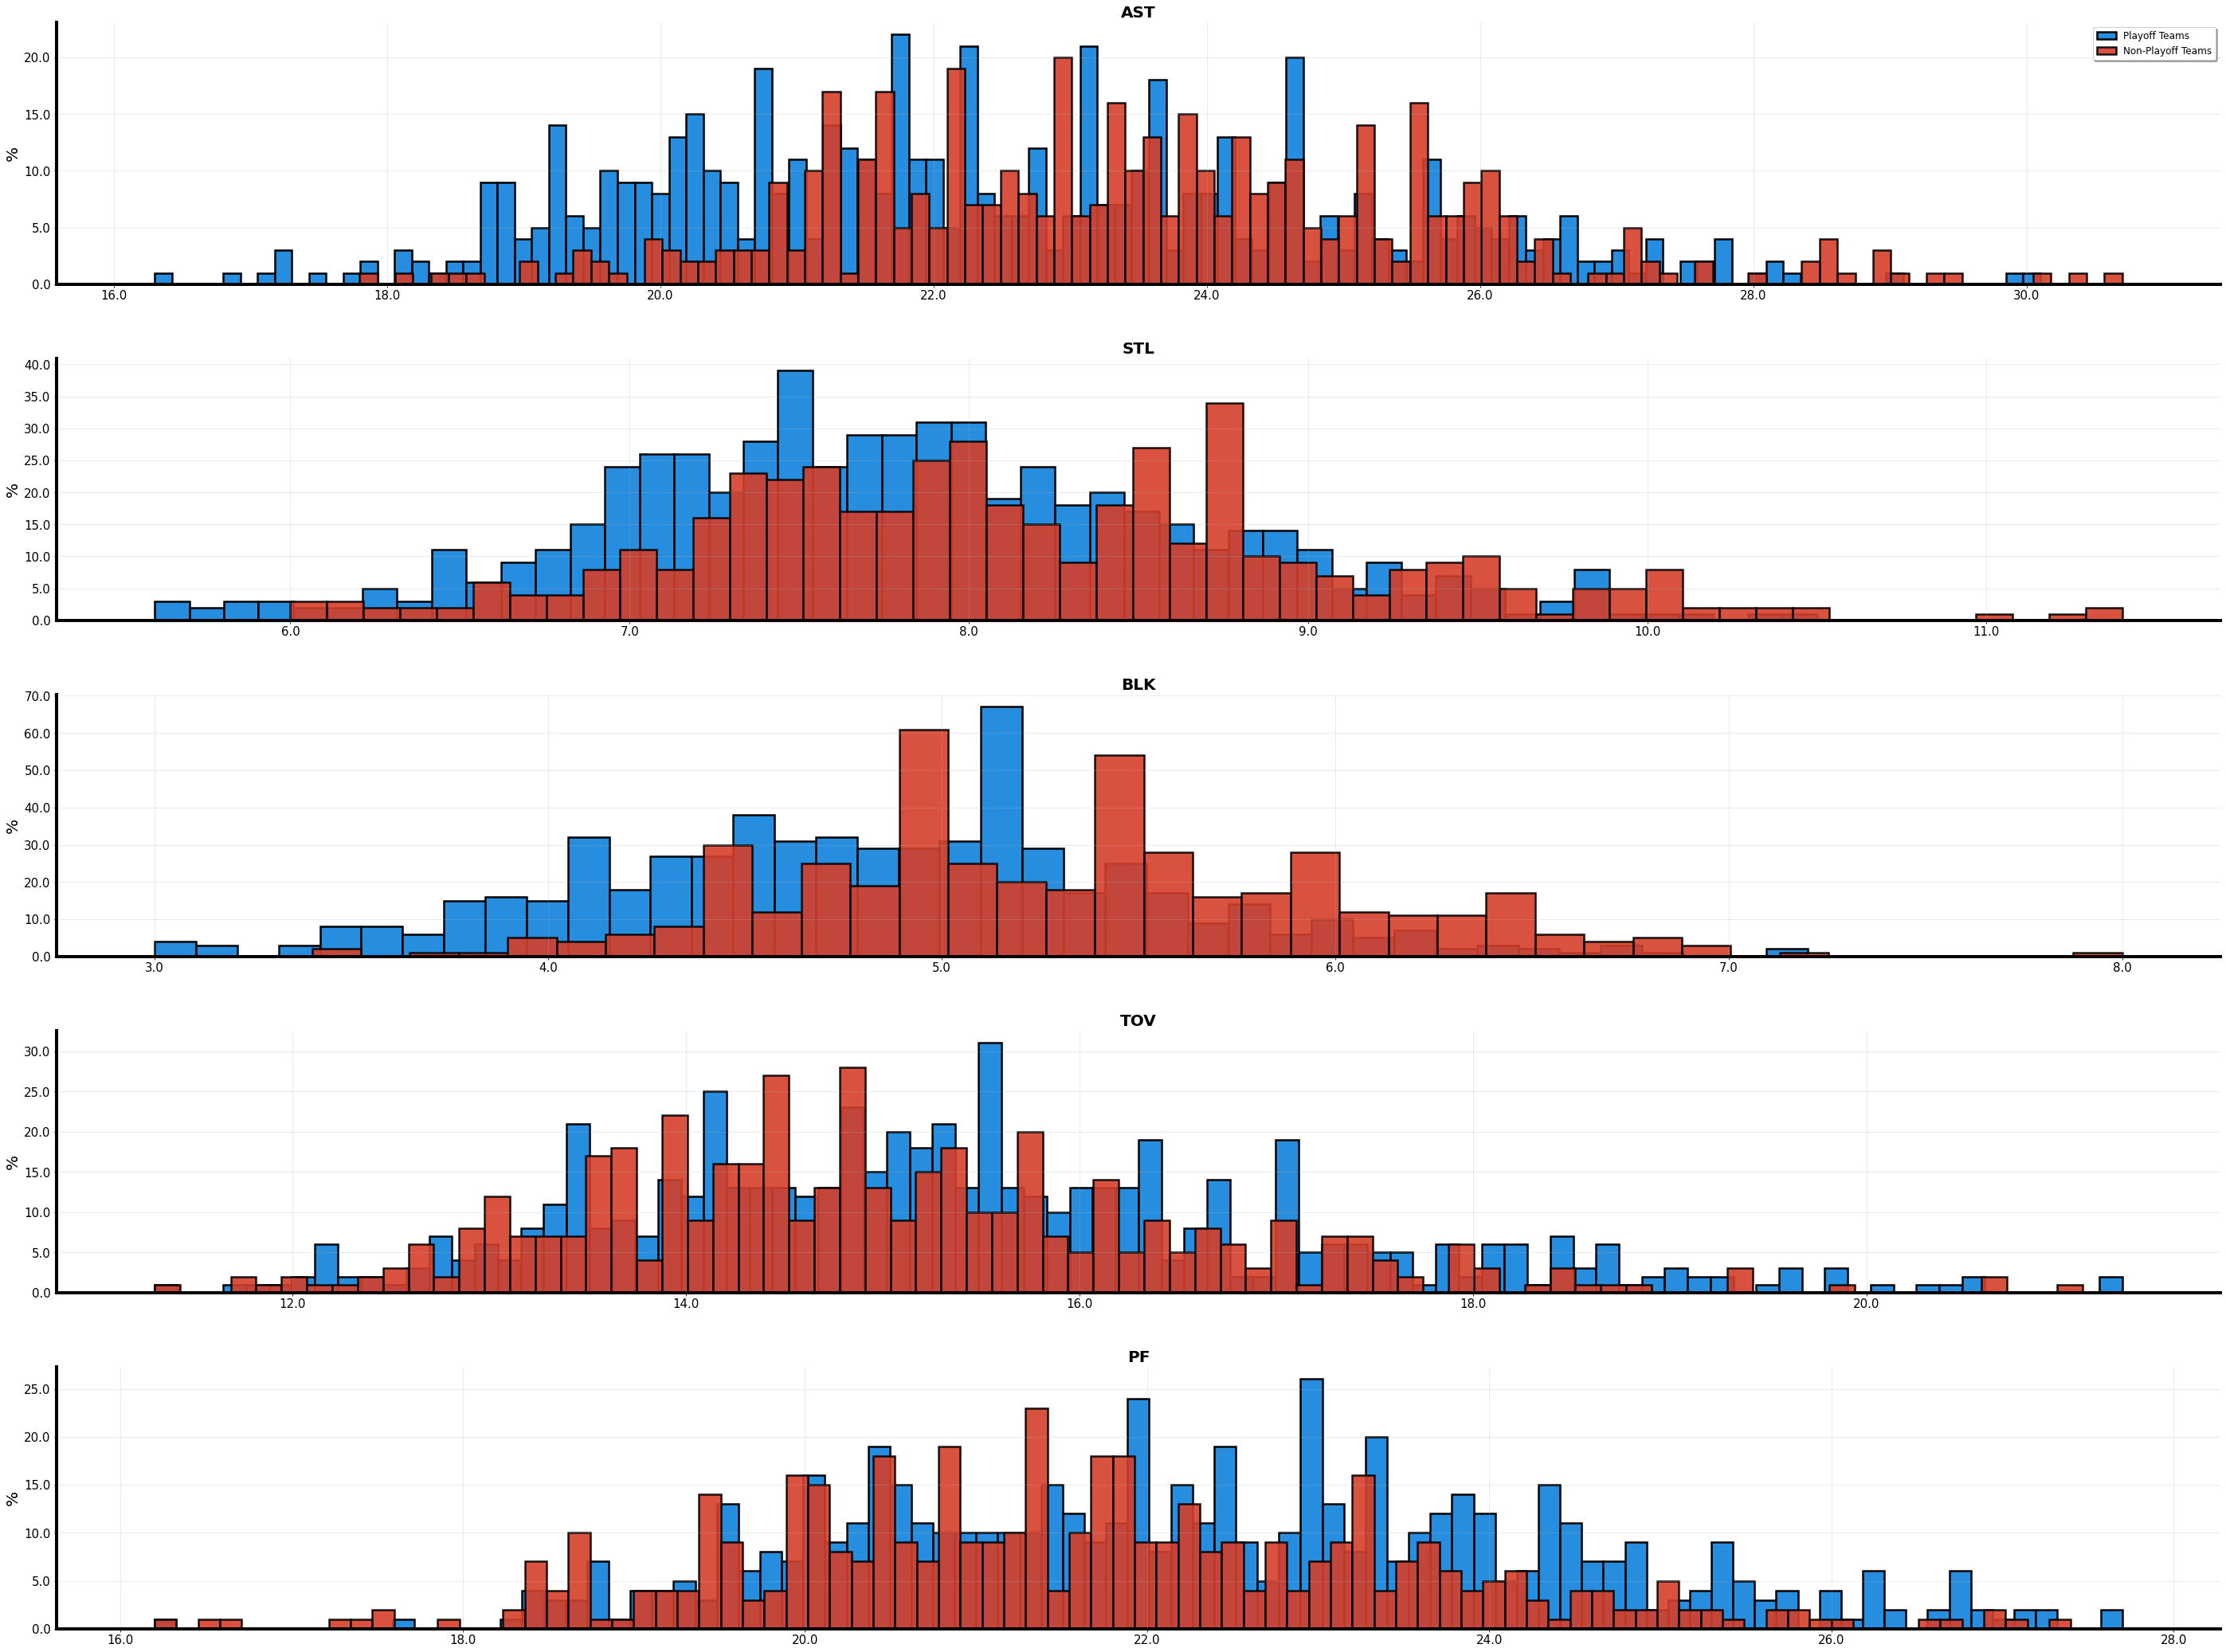

In [34]:
# playoff_defense_stats
# non_playoff_defense_stats

fig, ax = plt.subplots(5, 1, figsize=(40,30))

for i, col in enumerate(others):
    
    playoff_stats = playoff_defense_stats[col]
    playoff_bins = playoff_defense_stats[col].value_counts().size

    non_playoff_stats = non_playoff_defense_stats[col]
    non_playoff_bins = non_playoff_defense_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_stats, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_stats, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.4 Advanced Stats

In [35]:
advanced_stats.head()

,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Arena,Attend.,Attend./G,PLAYOFF,SEASON
0,1.0,Milwaukee Bucks,29.2,56.0,17.0,57,16,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,Fiserv Forum,549036,17711.0,1,2020
1,2.0,Boston Celtics,25.3,48.0,24.0,50,22,6.31,-0.47,5.83,113.3,107.0,6.3,99.5,0.259,0.386,0.570,0.531,12.2,23.9,0.207,0.509,13.5,77.4,0.215,TD Garden,610864,19090.0,1,2020
2,3.0,Los Angeles Clippers,27.4,49.0,23.0,50,22,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,STAPLES Center,610176,19068.0,1,2020
3,4.0,Toronto Raptors,26.6,53.0,19.0,50,22,6.24,-0.26,5.97,111.1,105.0,6.1,100.9,0.264,0.421,0.574,0.536,13.1,21.3,0.210,0.502,14.6,76.7,0.202,Scotiabank Arena,633456,19796.0,1,2020
4,5.0,Los Angeles Lakers,29.5,52.0,19.0,48,23,5.79,0.49,6.28,112.0,106.3,5.7,100.9,0.276,0.358,0.573,0.542,13.3,24.5,0.201,0.515,14.1,78.8,0.205,STAPLES Center,588907,18997.0,1,2020


In [36]:
playoff_advanced_stats=advanced_stats[advanced_stats["PLAYOFF"]==1]
playoff_advanced_stats.reset_index(drop=True, inplace=True)

non_playoff_advanced_stats=advanced_stats[advanced_stats["PLAYOFF"]==0]
non_playoff_advanced_stats.reset_index(drop=True, inplace=True)

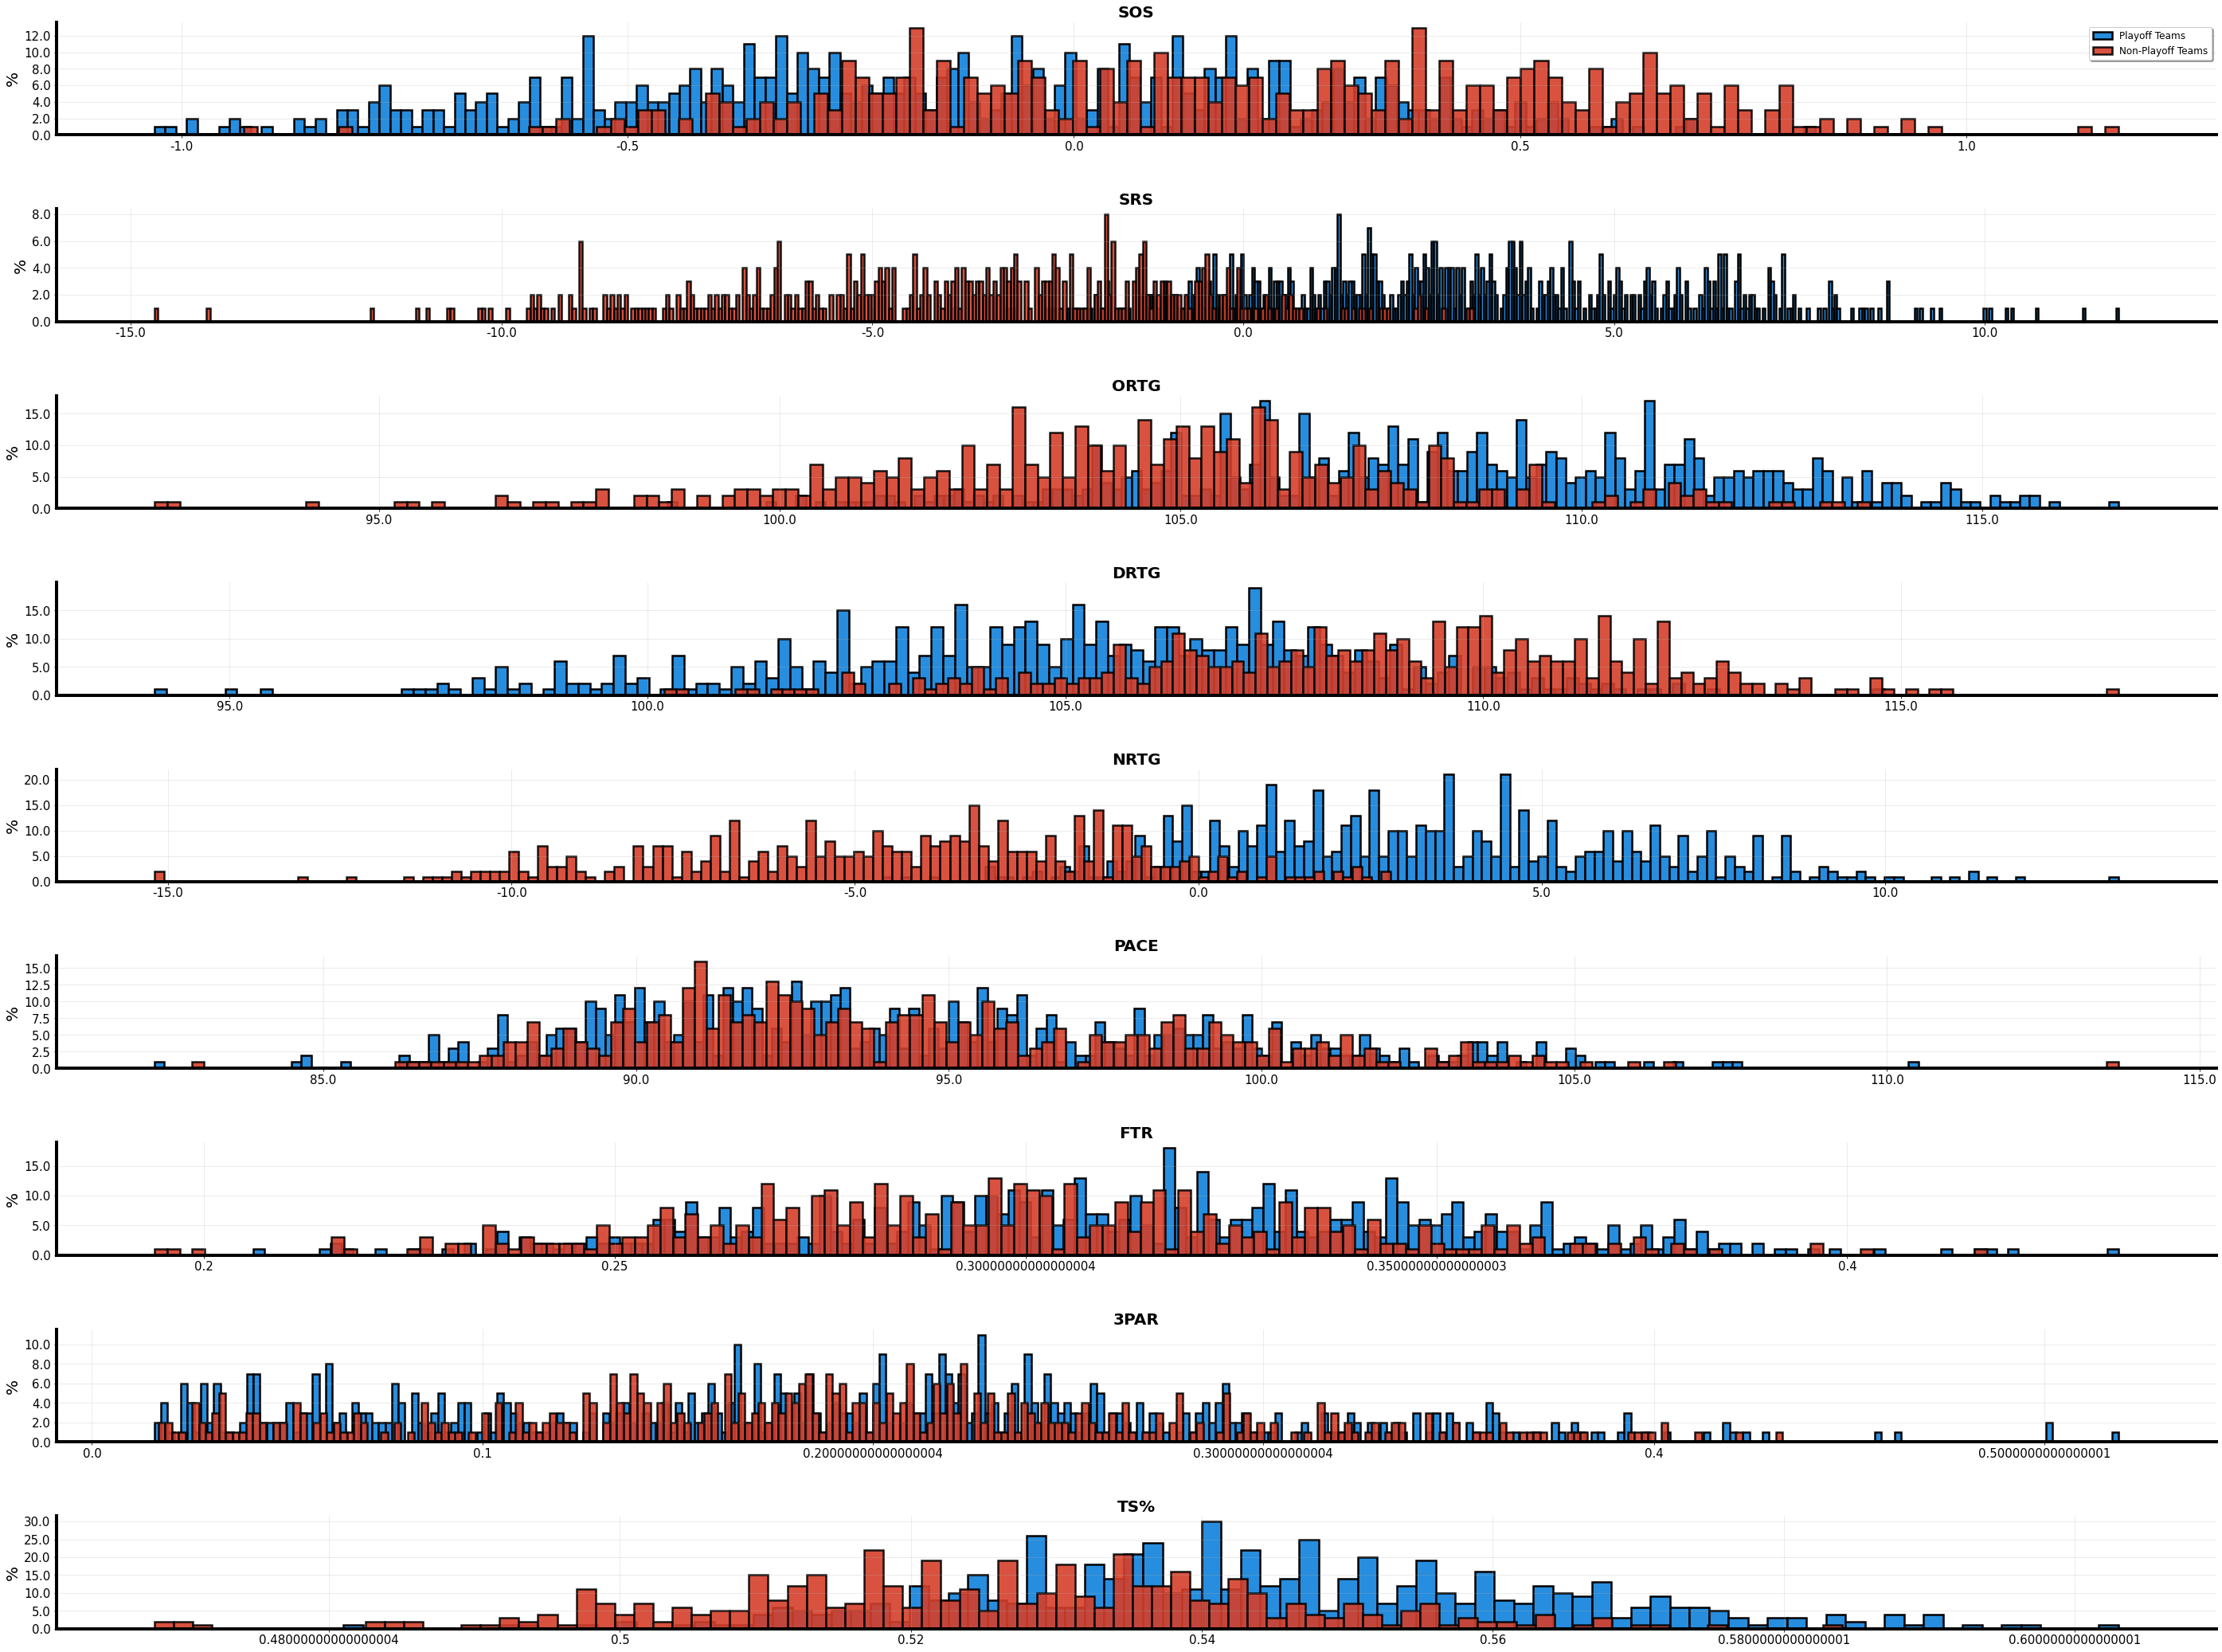

In [37]:
stats = ["SOS", "SRS", "ORtg", "DRtg", "NRtg", "Pace", "FTr", "3PAr", "TS%"]

fig, ax = plt.subplots(9, 1, figsize=(40,30))

for i, col in enumerate(stats):
    
    playoff_rebounds = playoff_advanced_stats[col]
    playoff_bins = playoff_advanced_stats[col].value_counts().size

    non_playoff_rebounds = non_playoff_advanced_stats[col]
    non_playoff_bins = non_playoff_advanced_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_rebounds, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_rebounds, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
#     ax.flatten()[i].set_xticks(np.arange(0, 83, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.4.2 Offense Four Factors

In [38]:
offense_four_factors = ["OeFG%", "OTOV%", "ORB%", "OFT/FGA"]


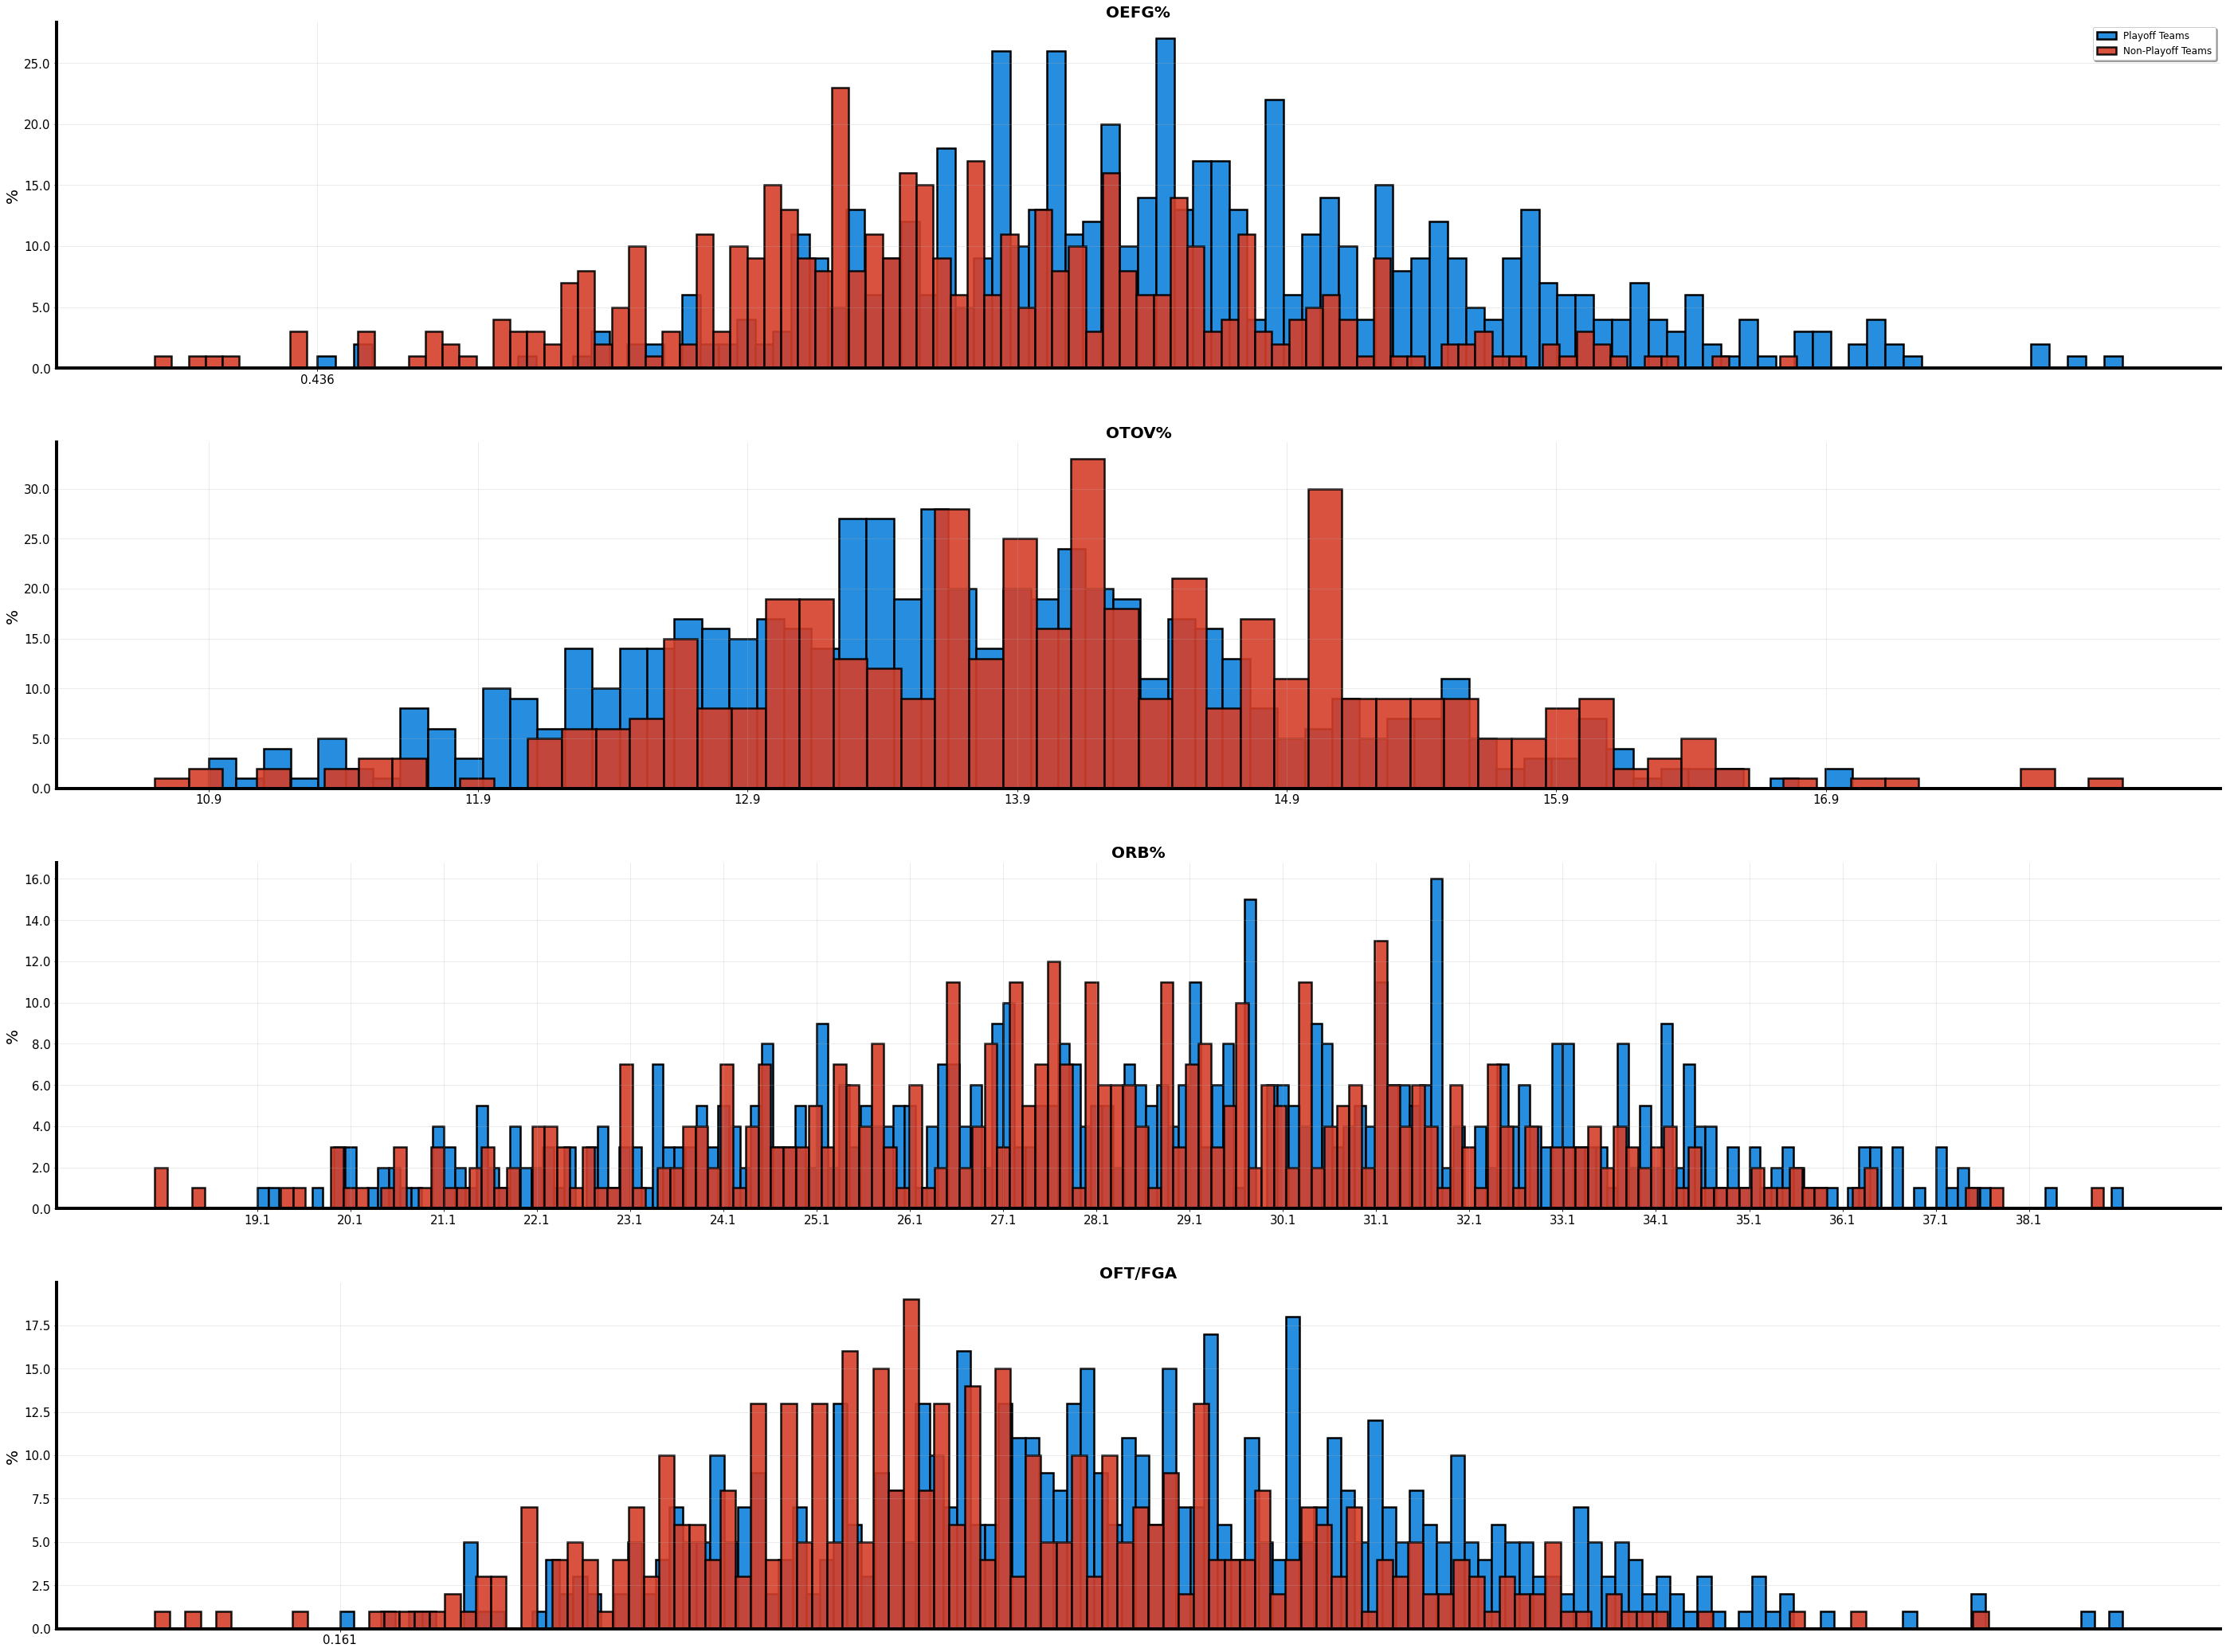

In [39]:
fig, ax = plt.subplots(4, 1, figsize=(40,30))

for i, col in enumerate(offense_four_factors):
    
    playoff_rebounds = playoff_advanced_stats[col]
    playoff_bins = playoff_advanced_stats[col].value_counts().size

    non_playoff_rebounds = non_playoff_advanced_stats[col]
    non_playoff_bins = non_playoff_advanced_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_rebounds, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_rebounds, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(min(playoff_advanced_stats[col]), max(playoff_advanced_stats[col])))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.4.3 Defense Four Factors

In [40]:
defense_four_factors = ["DeFG%", "DTOV%", "DRB%", "DFT/FGA"]

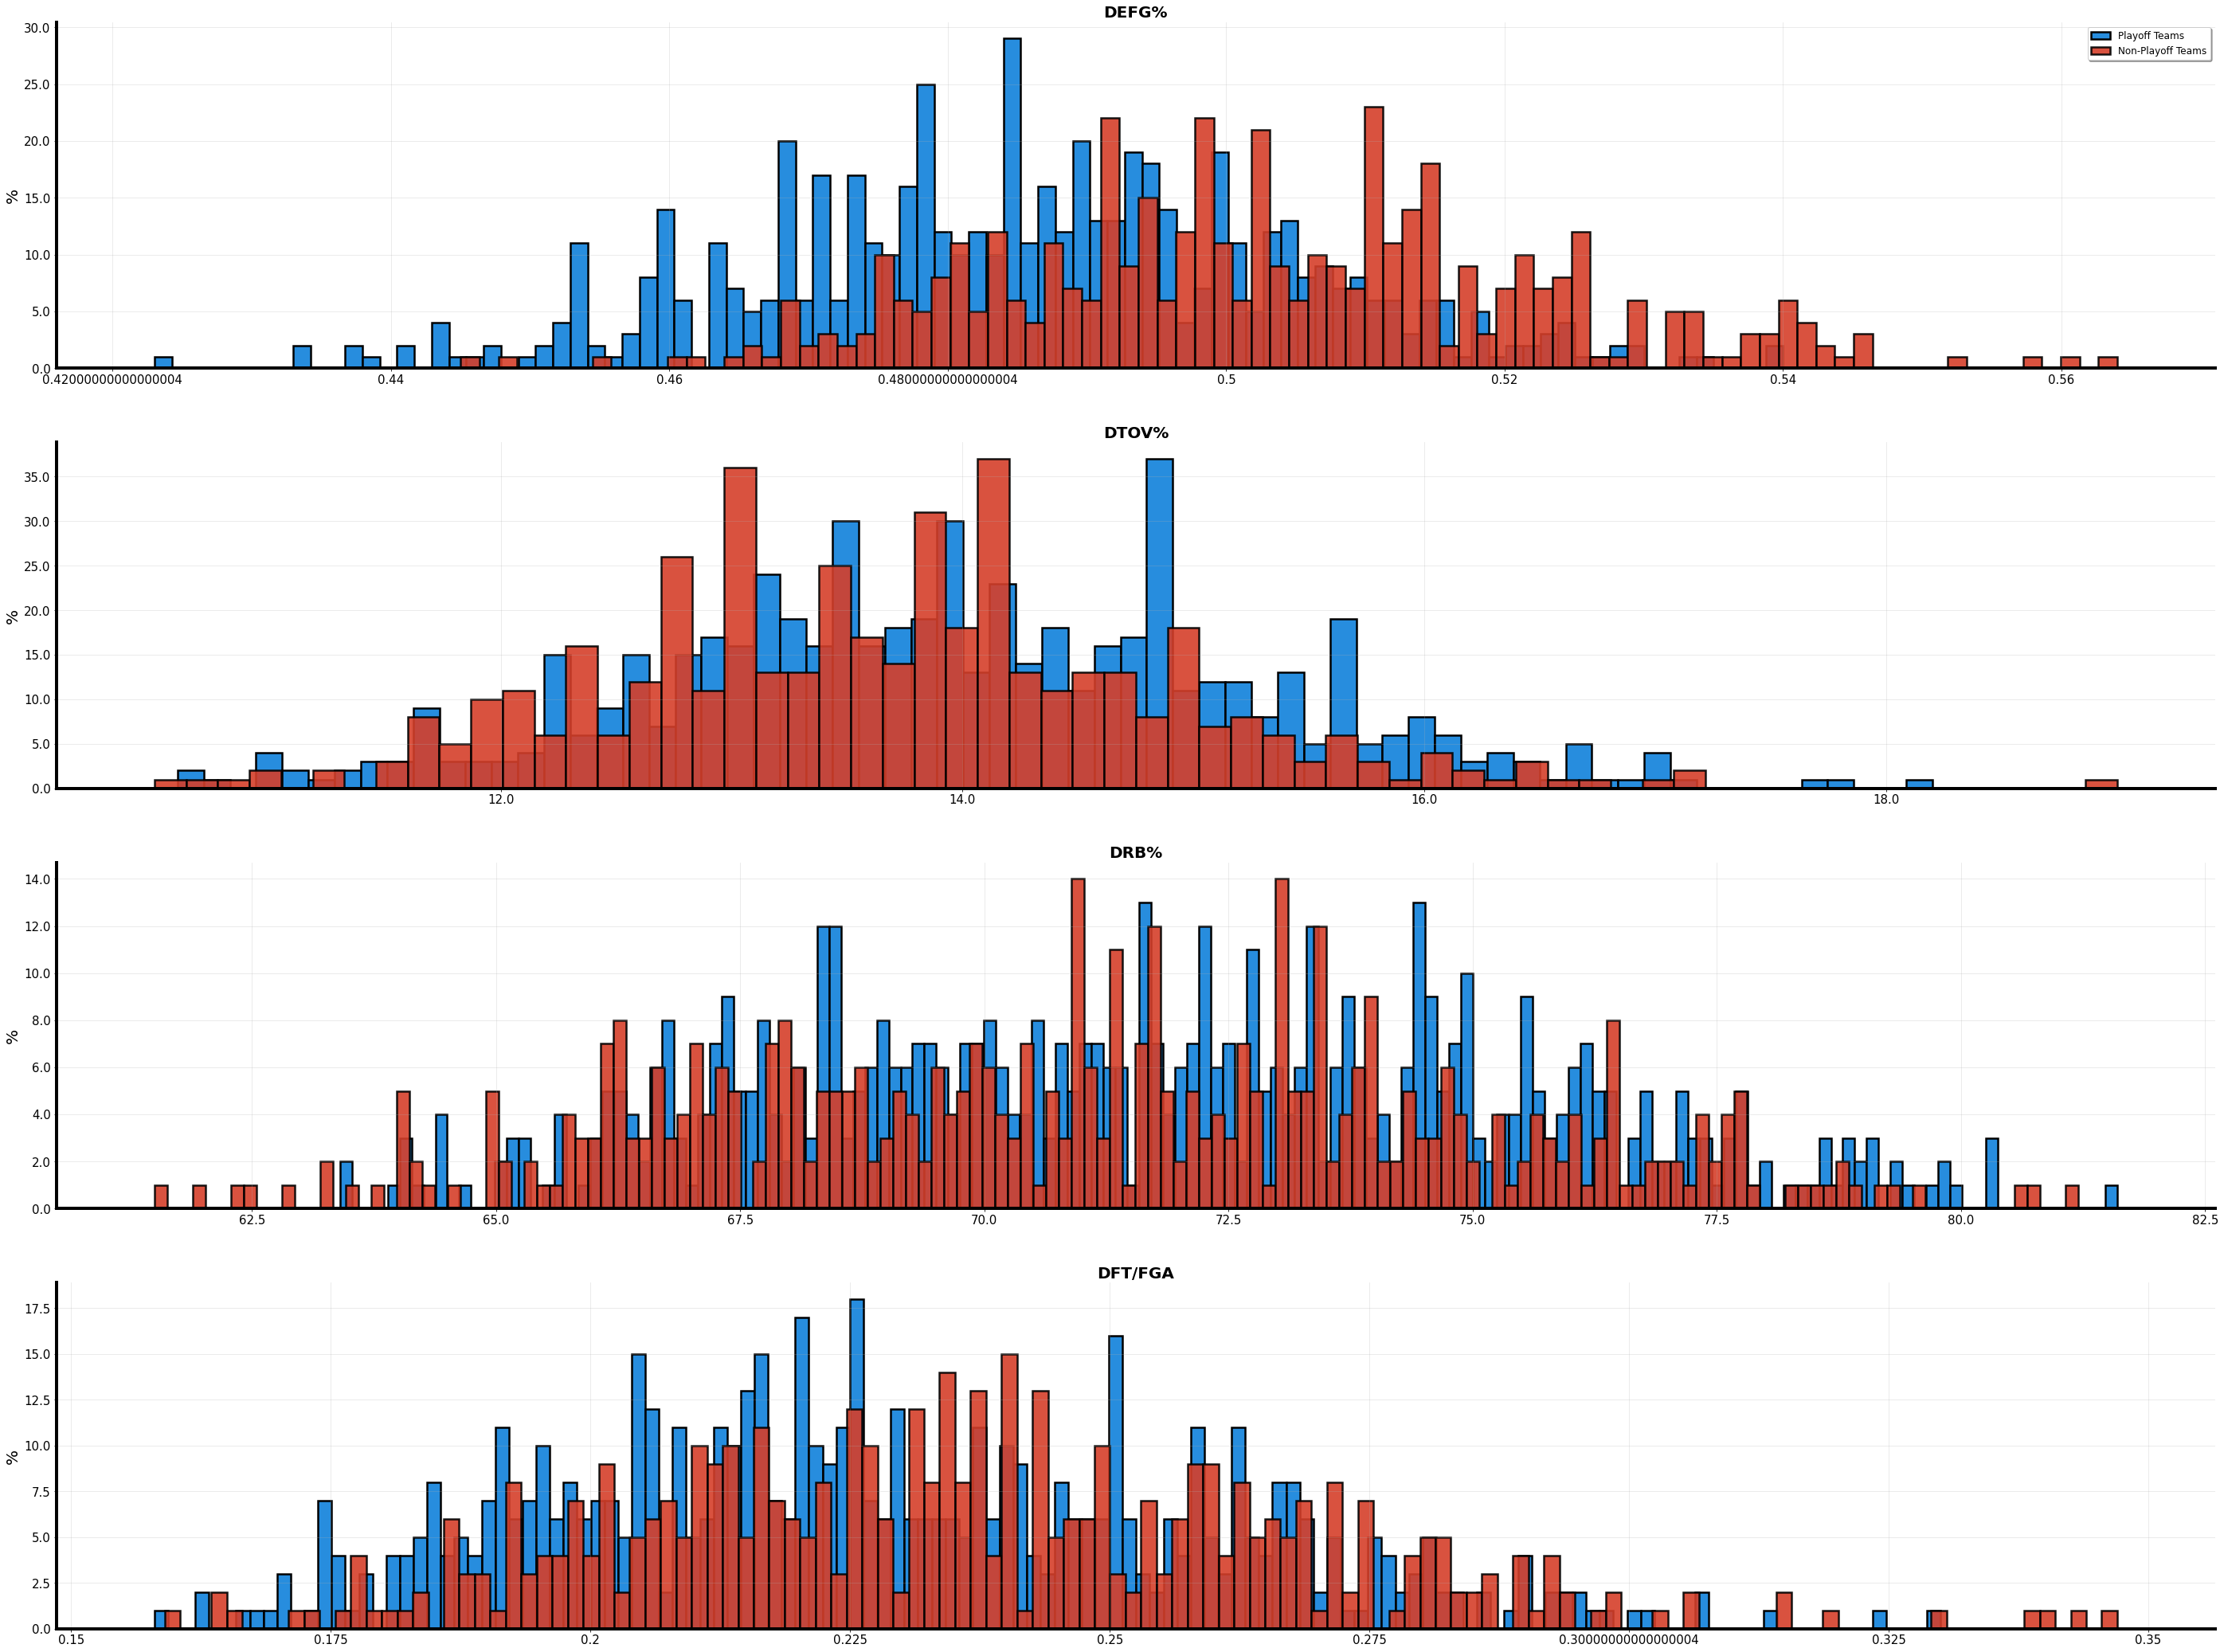

In [41]:
fig, ax = plt.subplots(4, 1, figsize=(40,30))

for i, col in enumerate(defense_four_factors):
    
    playoff_rebounds = playoff_advanced_stats[col]
    playoff_bins = playoff_advanced_stats[col].value_counts().size

    non_playoff_rebounds = non_playoff_advanced_stats[col]
    non_playoff_bins = non_playoff_advanced_stats[col].value_counts().size
    
    ax.flatten()[i].hist(playoff_rebounds, bins=playoff_bins, color=playoff_color, edgecolor='black', alpha=1, linewidth=2.5, label='Playoff Teams')
    ax.flatten()[i].hist(non_playoff_rebounds, bins=non_playoff_bins, color=non_playoff_color, edgecolor='black', alpha=0.9, linewidth=2.5, label='Non-Playoff Teams')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)

    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
#     ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
            
# fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

## 4.5 Stats by Season

In [42]:
seasons = np.flip(offense_stats['SEASON'].unique())

playoff_legend = mpatches.Patch(color=playoff_color, label='Playoff Teams', edgecolor='black')
non_playoff_legend = mpatches.Patch(color=non_playoff_color, label='Non-Playoff Teams', edgecolor='black')

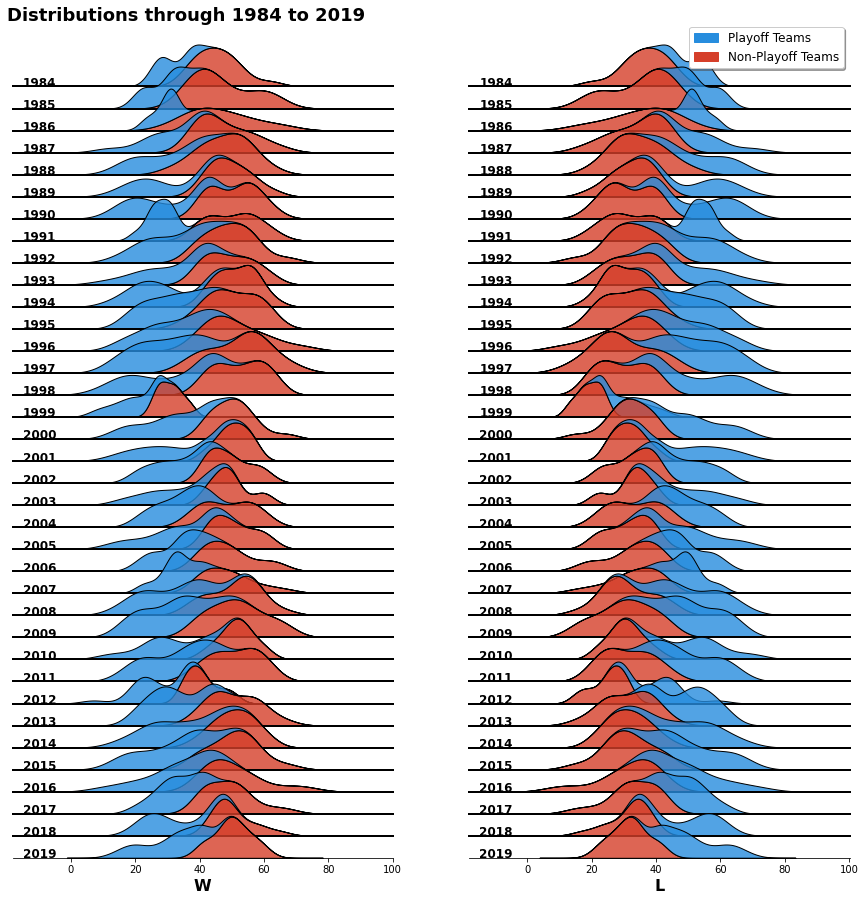

In [43]:
cols = ["W", "L"]

fig, ax = plt.subplots(len(seasons[:-1]), len(cols), figsize=(15, 15), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=advanced_stats[advanced_stats['SEASON']==season].squeeze(), x=col, hue='PLAYOFF',  alpha=.8,
                    palette=[playoff_color, non_playoff_color], edgecolor='black', multiple='stack', 
                    legend=False, ax=ax[j, i])
        
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
#             ax[j, i].set_xticks(np.arange(0, 40, 5))
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[playoff_legend, non_playoff_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1984 to 2019', fontsize=18, fontweight='bold')     
plt.show()

In [44]:
offense_defense_stats = offense_stats.merge(defense_stats, on=["Team", "G", "PLAYOFF", "SEASON"], how='inner', suffixes=('_Offense', '_Defense'))
final_stats = offense_defense_stats.merge(advanced_stats, on=["Team", "PLAYOFF", "SEASON"], how='inner')

In [45]:
teams = final_stats["Team"].unique()
team_id_dictionary = {team : team_id+1 for team_id, team in enumerate(teams)}
team_id = final_stats["Team"].map(team_id_dictionary)

In [46]:
columns_to_move = ["SEASON", "PLAYOFF"]

# Remove the columns from the DataFrame and store them
moved_columns = final_stats.pop(columns_to_move[0])
moved_columns = pd.concat([moved_columns, final_stats.pop(columns_to_move[1])], axis=1)

# Concatenate the moved columns back to the DataFrame in the desired order
final_stats = pd.concat([final_stats, moved_columns], axis=1)

In [47]:
final_stats.drop(["Team", "G", "Arena"], axis=1, inplace=True)
final_stats

,Rk_Offense,MP_Offense,FG_Offense,FGA_Offense,FG%_Offense,3P_Offense,3PA_Offense,3P%_Offense,2P_Offense,2PA_Offense,2P%_Offense,FT_Offense,FTA_Offense,FT%_Offense,ORB_Offense,DRB_Offense,TRB_Offense,AST_Offense,STL_Offense,BLK_Offense,TOV_Offense,PF_Offense,PTS_Offense,Rk_Defense,MP_Defense,FG_Defense,FGA_Defense,FG%_Defense,3P_Defense,3PA_Defense,3P%_Defense,2P_Defense,2PA_Defense,2P%_Defense,FT_Defense,FTA_Defense,FT%_Defense,ORB_Defense,DRB_Defense,TRB_Defense,AST_Defense,STL_Defense,BLK_Defense,TOV_Defense,PF_Defense,PTS_Defense,Rk,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Attend.,Attend./G,SEASON,PLAYOFF
0,1.0,241.0,43.3,90.9,0.476,13.8,38.9,0.355,29.5,52.0,0.567,18.3,24.7,0.742,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7,8.0,241.0,38.9,94.0,0.414,14.0,39.3,0.355,25.0,54.7,0.457,16.7,21.2,0.787,9.5,36.3,45.8,24.2,7.4,4.5,14.1,21.7,108.6,1.0,29.2,56.0,17.0,57,16,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,549036,17711.0,2020,1
1,2.0,241.4,40.8,90.4,0.451,15.6,45.3,0.345,25.1,45.2,0.557,20.6,26.1,0.791,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8,22.0,241.4,42.3,91.5,0.462,12.2,35.0,0.349,30.1,56.5,0.532,18.0,23.7,0.761,11.2,36.7,47.9,25.3,8.0,4.9,16.2,21.0,114.8,8.0,29.2,44.0,28.0,42,30,2.96,0.17,3.13,112.9,110.1,2.8,103.7,0.288,0.501,0.578,0.537,12.6,21.0,0.228,0.529,13.7,75.6,0.197,578458,18077.0,2020,1
2,3.0,242.3,41.7,90.3,0.461,15.1,41.3,0.367,26.5,49.0,0.541,18.6,23.8,0.779,10.5,36.4,46.9,24.7,6.1,4.8,12.7,19.5,117.0,17.0,242.3,41.9,91.6,0.458,12.3,34.9,0.351,29.7,56.7,0.523,16.0,21.0,0.760,10.4,35.0,45.4,23.9,7.0,4.1,11.9,21.3,112.1,6.0,26.1,43.0,32.0,49,26,4.95,-0.07,4.87,116.7,111.7,5.0,99.3,0.264,0.457,0.581,0.545,11.2,23.2,0.206,0.525,10.6,77.7,0.175,682096,20062.0,2020,1
3,4.0,241.4,41.6,89.2,0.466,12.4,33.5,0.371,29.1,55.8,0.522,20.8,26.3,0.791,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3,13.0,241.4,39.5,90.2,0.438,12.3,35.6,0.345,27.2,54.6,0.499,18.5,24.5,0.756,10.7,34.6,45.3,23.7,7.5,4.7,14.1,22.9,109.9,3.0,27.4,49.0,23.0,50,22,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,610176,19068.0,2020,1
4,5.0,242.1,42.6,91.6,0.465,13.6,36.9,0.370,28.9,54.8,0.528,17.1,23.4,0.729,11.1,35.4,46.5,26.8,7.5,5.0,16.4,21.2,115.8,27.0,242.1,42.7,91.8,0.465,12.2,33.9,0.361,30.5,58.0,0.526,19.4,24.7,0.789,10.1,34.7,44.8,24.5,8.5,4.8,14.5,21.1,117.1,20.0,25.4,30.0,42.0,33,39,-1.29,0.74,-0.55,110.7,111.9,-1.2,103.7,0.256,0.403,0.568,0.539,13.9,24.2,0.186,0.532,12.4,77.8,0.212,528172,16505.0,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,19.0,241.2,42.0,87.0,0.483,0.6,2.5,0.232,41.5,84.4,0.491,19.8,25.8,0.766,12.2,29.2,41.5,26.5,10.2,4.9,18.6,25.1,104.5,11.0,241.2,43.3,87.5,0.495,0.4,1.8,0.199,43.0,85.7,0.501,22.3,29.5,0.757,14.6,31.3,45.8,25.8,9.3,5.4,19.4,23.5,109.3,22.0,24.4,26.0,56.0,28,54,-4.82,0.57,-4.25,101.8,106.5,-4.7,102.1,0.297,0.029,0.531,0.487,15.9,28.1,0.228,0.497,16.2,66.8,0.255,410626,10015.0,1984,0
1039,20.0,243.7,40.3,85.0,0.474,0.2,1.4,0.171,40.1,83.6,0.479,22.8,30.6,0.746,13.9,28.0,42.0,25.5,8.4,5.5,19.2,26.8,103.7,9.0,243.7,42.7,86.4,0.494,0.5,2.2,0.203,42.3,84.1,0.502,23.0,30.1,0.763,13.7,29.1,42.8,27.3,9.6,6.3,18.5,25.7,108.9,23.0,24.4,27.0,55.0,28,54,-5.18,0.50,-4.69,102.4,107.5,-5.1,99.8,0.360,0.017,0.526,0.475,16.3,32.3,0.268,0.497,15.6,67.2,0.266,256430,6254.0,1984,0
1040,21.0,242.7,40.8,84.2,0.484,0.9,3.4,0.252,39.9,80.8,0.494,20.3,26.8,0.756,12.5,29.1,41.6,26.7,6.8,3.9,17.7,24.3,102.7,5.0,242.7,42.3,86.4,0.489,0.5,2.1,0.215,41.8,84.3,0.496,20.6,27.0,0.763,12.6,29.0,41.7,24.9,8.6,6.0,15.6,24.6,105.6,18.0,26.2,35.0,47.0,33,49,-2.89,0.53,-2.36,104.2,107.2,-3.0,97.4,0.319,0.04

## Feature Selection

In [ ]:
p_season_corr = final_stats.corr()

plt.figure(figsize=(20,20))
sns.heatmap(p_season_corr, 
            mask=np.zeros_like(p_season_corr, dtype=np.bool), 
            annot=True, cmap=sns.cubehelix_palette(as_cmap=True), square=True, linewidths=0.1)
plt.show()

In [49]:
corr = p_season_corr["PLAYOFF"].map(abs).sort_values(ascending=False)
top_correlated_columns = corr[corr>0.4].index
top_correlated_columns

Index(['PLAYOFF', 'Rk', 'W', 'L', 'NRtg', 'MOV', 'PW', 'SRS', 'PL', 'ORtg',
       'DRtg', 'Rk_Defense', 'TS%', 'Age', 'DeFG%', 'FG%_Offense', 'SOS'],
      dtype='object')

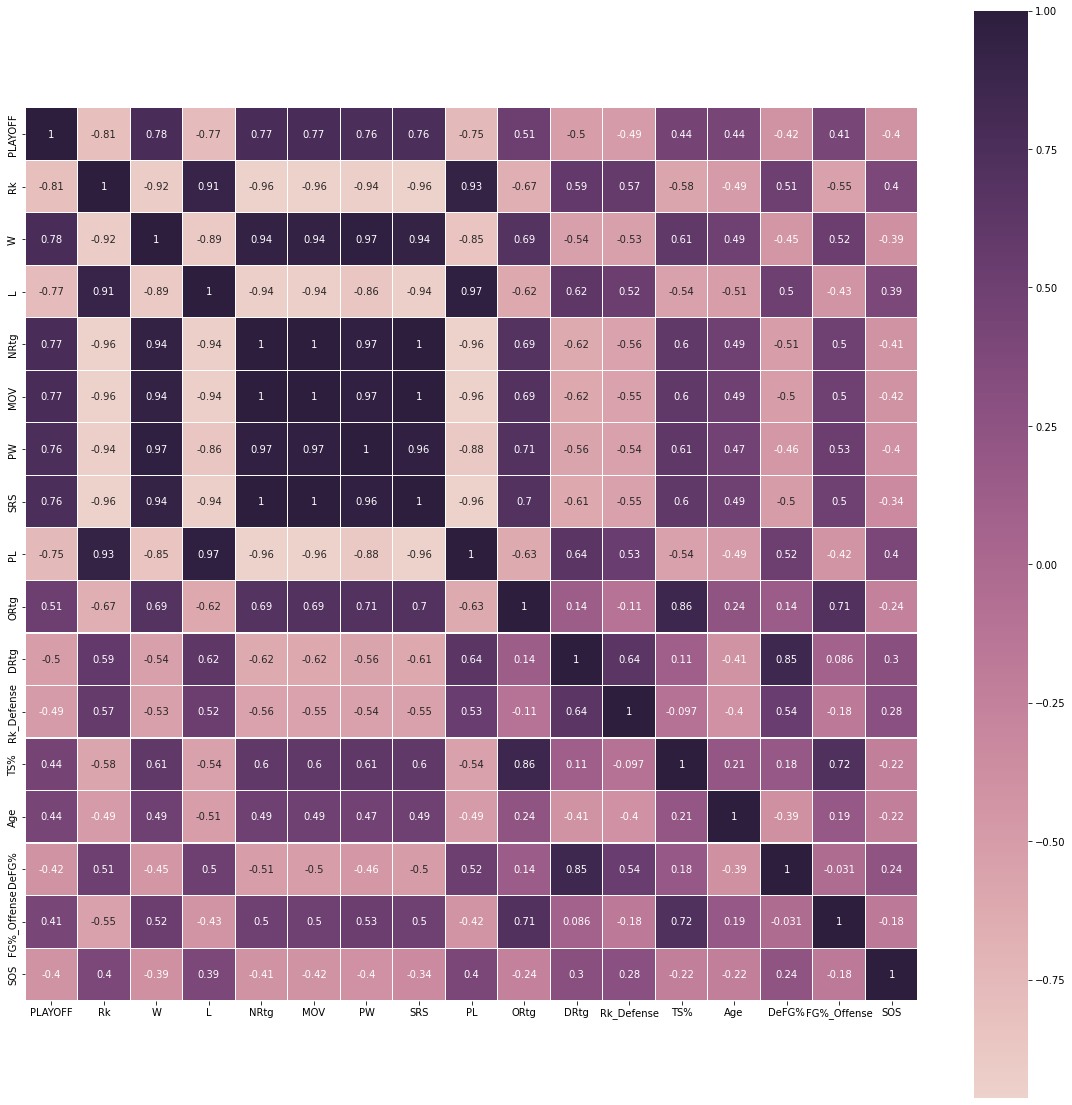

In [50]:
p_season_corr = final_stats[top_correlated_columns].corr()

plt.figure(figsize=(20,20))
sns.heatmap(p_season_corr, 
            mask=np.zeros_like(p_season_corr, dtype=np.bool), 
            annot=True, cmap=sns.cubehelix_palette(as_cmap=True), square=True, linewidths=0.1)
plt.show()

# 5. Modeling

## 5.1 Baseline Model

- LinearSVM
- LogisticRegression
- RandomForest

In [51]:
final_stats["Team_ID"] = team_id

In [52]:
# # team_id_dictionary
# team_id
final_stats

,Rk_Offense,MP_Offense,FG_Offense,FGA_Offense,FG%_Offense,3P_Offense,3PA_Offense,3P%_Offense,2P_Offense,2PA_Offense,2P%_Offense,FT_Offense,FTA_Offense,FT%_Offense,ORB_Offense,DRB_Offense,TRB_Offense,AST_Offense,STL_Offense,BLK_Offense,TOV_Offense,PF_Offense,PTS_Offense,Rk_Defense,MP_Defense,FG_Defense,FGA_Defense,FG%_Defense,3P_Defense,3PA_Defense,3P%_Defense,2P_Defense,2PA_Defense,2P%_Defense,FT_Defense,FTA_Defense,FT%_Defense,ORB_Defense,DRB_Defense,TRB_Defense,AST_Defense,STL_Defense,BLK_Defense,TOV_Defense,PF_Defense,PTS_Defense,Rk,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Attend.,Attend./G,SEASON,PLAYOFF,Team_ID
0,1.0,241.0,43.3,90.9,0.476,13.8,38.9,0.355,29.5,52.0,0.567,18.3,24.7,0.742,9.5,42.2,51.7,25.9,7.2,5.9,15.1,19.6,118.7,8.0,241.0,38.9,94.0,0.414,14.0,39.3,0.355,25.0,54.7,0.457,16.7,21.2,0.787,9.5,36.3,45.8,24.2,7.4,4.5,14.1,21.7,108.6,1.0,29.2,56.0,17.0,57,16,10.08,-0.67,9.41,112.4,102.9,9.5,105.1,0.271,0.428,0.583,0.552,12.9,20.7,0.201,0.489,12.0,81.6,0.178,549036,17711.0,2020,1,1
1,2.0,241.4,40.8,90.4,0.451,15.6,45.3,0.345,25.1,45.2,0.557,20.6,26.1,0.791,9.8,34.5,44.3,21.6,8.7,5.2,14.7,21.8,117.8,22.0,241.4,42.3,91.5,0.462,12.2,35.0,0.349,30.1,56.5,0.532,18.0,23.7,0.761,11.2,36.7,47.9,25.3,8.0,4.9,16.2,21.0,114.8,8.0,29.2,44.0,28.0,42,30,2.96,0.17,3.13,112.9,110.1,2.8,103.7,0.288,0.501,0.578,0.537,12.6,21.0,0.228,0.529,13.7,75.6,0.197,578458,18077.0,2020,1,2
2,3.0,242.3,41.7,90.3,0.461,15.1,41.3,0.367,26.5,49.0,0.541,18.6,23.8,0.779,10.5,36.4,46.9,24.7,6.1,4.8,12.7,19.5,117.0,17.0,242.3,41.9,91.6,0.458,12.3,34.9,0.351,29.7,56.7,0.523,16.0,21.0,0.760,10.4,35.0,45.4,23.9,7.0,4.1,11.9,21.3,112.1,6.0,26.1,43.0,32.0,49,26,4.95,-0.07,4.87,116.7,111.7,5.0,99.3,0.264,0.457,0.581,0.545,11.2,23.2,0.206,0.525,10.6,77.7,0.175,682096,20062.0,2020,1,3
3,4.0,241.4,41.6,89.2,0.466,12.4,33.5,0.371,29.1,55.8,0.522,20.8,26.3,0.791,10.7,37.0,47.7,23.7,7.1,4.7,14.6,22.1,116.3,13.0,241.4,39.5,90.2,0.438,12.3,35.6,0.345,27.2,54.6,0.499,18.5,24.5,0.756,10.7,34.6,45.3,23.7,7.5,4.7,14.1,22.9,109.9,3.0,27.4,49.0,23.0,50,22,6.44,0.21,6.66,113.9,107.6,6.3,101.5,0.295,0.375,0.577,0.535,12.6,23.5,0.233,0.506,12.2,77.6,0.206,610176,19068.0,2020,1,4
4,5.0,242.1,42.6,91.6,0.465,13.6,36.9,0.370,28.9,54.8,0.528,17.1,23.4,0.729,11.1,35.4,46.5,26.8,7.5,5.0,16.4,21.2,115.8,27.0,242.1,42.7,91.8,0.465,12.2,33.9,0.361,30.5,58.0,0.526,19.4,24.7,0.789,10.1,34.7,44.8,24.5,8.5,4.8,14.5,21.1,117.1,20.0,25.4,30.0,42.0,33,39,-1.29,0.74,-0.55,110.7,111.9,-1.2,103.7,0.256,0.403,0.568,0.539,13.9,24.2,0.186,0.532,12.4,77.8,0.212,528172,16505.0,2020,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,19.0,241.2,42.0,87.0,0.483,0.6,2.5,0.232,41.5,84.4,0.491,19.8,25.8,0.766,12.2,29.2,41.5,26.5,10.2,4.9,18.6,25.1,104.5,11.0,241.2,43.3,87.5,0.495,0.4,1.8,0.199,43.0,85.7,0.501,22.3,29.5,0.757,14.6,31.3,45.8,25.8,9.3,5.4,19.4,23.5,109.3,22.0,24.4,26.0,56.0,28,54,-4.82,0.57,-4.25,101.8,106.5,-4.7,102.1,0.297,0.029,0.531,0.487,15.9,28.1,0.228,0.497,16.2,66.8,0.255,410626,10015.0,1984,0,23
1039,20.0,243.7,40.3,85.0,0.474,0.2,1.4,0.171,40.1,83.6,0.479,22.8,30.6,0.746,13.9,28.0,42.0,25.5,8.4,5.5,19.2,26.8,103.7,9.0,243.7,42.7,86.4,0.494,0.5,2.2,0.203,42.3,84.1,0.502,23.0,30.1,0.763,13.7,29.1,42.8,27.3,9.6,6.3,18.5,25.7,108.9,23.0,24.4,27.0,55.0,28,54,-5.18,0.50,-4.69,102.4,107.5,-5.1,99.8,0.360,0.017,0.526,0.475,16.3,32.3,0.268,0.497,15.6,67.2,0.266,256430,6254.0,1984,0,27
1040,21.0,242.7,40.8,84.2,0.484,0.9,3.4,0.252,39.9,80.8,0.494,20.3,26.8,0.756,12.5,29.1,41.6,26.7,6.8,3.9,17.7,24.3,102.7,5.0,242.7,42.3,86.4,0.489,0.5,2.1,0.215,41.8,84.3,0.496,20.6,27.0,0.763,12.6,29.0,41.7,24.9,8.6,6.0,15.6,24.6,105.6,18.0,26.2,35.0,47.0,33,49,-2.89,0.53,-2.36,104.

In [53]:
train = final_stats[final_stats["SEASON"]!=2020]
test = final_stats[final_stats["SEASON"]==2020]

In [54]:
top_correlated_columns[4:]

Index(['NRtg', 'MOV', 'PW', 'SRS', 'PL', 'ORtg', 'DRtg', 'Rk_Defense', 'TS%',
       'Age', 'DeFG%', 'FG%_Offense', 'SOS'],
      dtype='object')

In [55]:
X = train[top_correlated_columns[4:]].iloc[:,2:]
y = train["PLAYOFF"]

X_test = test[top_correlated_columns[4:]].iloc[:,2:]
y_test = test["PLAYOFF"]

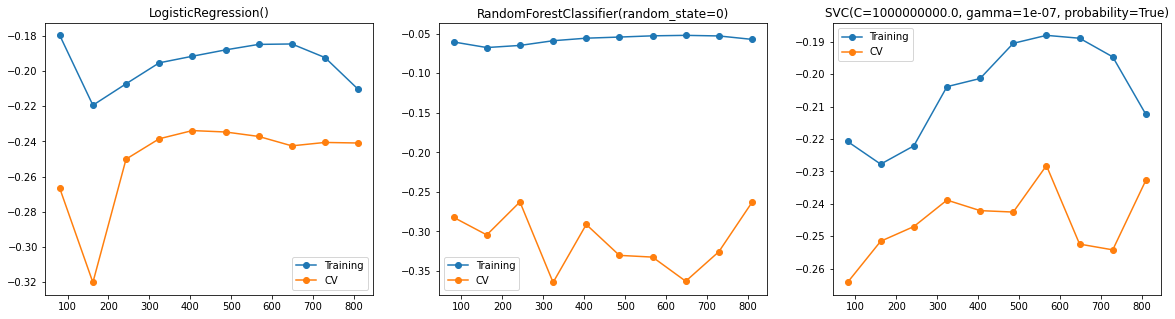

In [56]:
models = [ LogisticRegression(),\
           RandomForestClassifier(random_state=0),\
           SVC(kernel="rbf", C=1e9, gamma=1e-07, probability=True) ]

model = LogisticRegression()

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, model in enumerate(models):
    
    train_sizes, train_score, valid_scores = learning_curve(model, X, y, cv=5, 
                                                            train_sizes = np.linspace(0.1,1.0,10),
                                                            scoring="neg_log_loss")

    ax[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', label='Training')
    ax[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label='CV')
    ax[i].legend()
    ax[i].set_title(f'{model}')

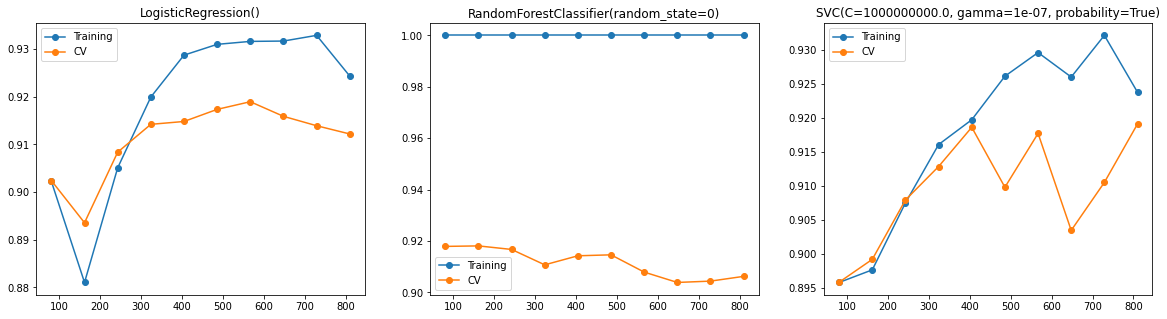

In [57]:
models = [ LogisticRegression(),\
           RandomForestClassifier(random_state=0),\
           SVC(kernel="rbf", C=1e9, gamma=1e-07, probability=True) ]

model = LogisticRegression()

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, model in enumerate(models):
    
    train_sizes, train_score, valid_scores = learning_curve(model, X, y, cv=5, 
                                                            train_sizes = np.linspace(0.1,1.0,10),
                                                            scoring="f1")

    ax[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', label='Training')
    ax[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label='CV')
    ax[i].legend()
    ax[i].set_title(f'{model}')

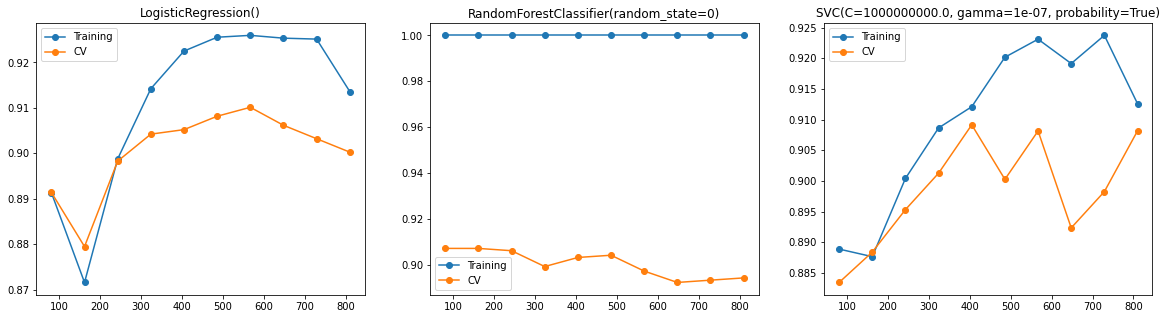

In [58]:
models = [ LogisticRegression(),\
           RandomForestClassifier(random_state=0),\
           SVC(kernel="rbf", C=1e9, gamma=1e-07, probability=True) ]

model = LogisticRegression()

fig, ax = plt.subplots(1,3, figsize=(20,5))
for i, model in enumerate(models):
    
    train_sizes, train_score, valid_scores = learning_curve(model, X, y, cv=5, 
                                                            train_sizes = np.linspace(0.1,1.0,10),
                                                            scoring="accuracy")

    ax[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', label='Training')
    ax[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label='CV')
    ax[i].legend()
    ax[i].set_title(f'{model}')

# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [134]:
def test_svc(X, y, X_test, y_test, kernel="rbf"):
    svc_model = SVC(kernel=kernel, probability=True).fit(X, y)
    y_pred = svc_model.predict_proba(X_test)
    log_score = log_loss(y_test, y_pred)    
    y_pred = svc_model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return log_score, acc_score, f1, y_pred


def test_logistic(X, y, X_test, y_test):
    logis_model = LogisticRegression().fit(X, y)
    y_pred = logis_model.predict_proba(X_test)
    log_score = log_loss(y_test, y_pred)
    y_pred = logis_model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return log_score , acc_score, f1, y_pred


def test_randomforest(X, y, X_test, y_test):
    random_model = RandomForestClassifier( n_estimators=50,  
                                           min_samples_split=2,
                                           max_depth=10,
                                           min_samples_leaf=1,
                                           max_features='auto' ).fit(X, y)
    y_pred = random_model.predict_proba(X_test)
    log_score = log_loss(y_test, y_pred)
    y_pred = random_model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return log_score , acc_score, f1 , y_pred

In [135]:
svc_log_score, svc_acc_score, svc_f1_score, test_svc_pred  = test_svc(X, y, X_test, y_test, kernel="poly")
lr_log_score, lr_acc_score, lr_f1_score, test_lr_pred = test_logistic(X, y, X_test, y_test)
rf_log_score, rf_acc_score, rf_f1_score, test_rf_pred = test_randomforest(X, y, X_test, y_test)

In [136]:
print("Log Loss")
print(f"SVC : {svc_log_score:.3f}")
print(f"Logistic Regression : {lr_log_score:.3f}")
print(f"RandomForest : {rf_log_score:.3f}")
print("\n")

print("Accuracy Score")
print(f"SVC : {svc_acc_score:.3f}")
print(f"Logistic Regression : {lr_acc_score:.3f}")
print(f"RandomForest : {rf_acc_score:.3f}")
print("\n")

print("F1 Score")
print(f"SVC : {svc_f1_score:.3f}")
print(f"Logistic Regression : {lr_f1_score:.3f}")
print(f"RandomForest : {rf_f1_score:.3f}")

Log Loss
SVC : 0.186
Logistic Regression : 0.185
RandomForest : 0.253


Accuracy Score
SVC : 0.933
Logistic Regression : 0.933
RandomForest : 0.900


F1 Score
SVC : 0.938
Logistic Regression : 0.933
RandomForest : 0.897


In [146]:
voting_classifier = VotingClassifier(estimators=[('SVC', SVC(kernel="poly", probability=True)), 
                                                 ('LogisticRegression',LogisticRegression()), 
                                                 ('RandomForest', RandomForestClassifier( n_estimators=50,  
                                                                                          min_samples_split=2,
                                                                                          max_depth=10,
                                                                                          min_samples_leaf=1,
                                                                                          max_features='auto' ))],
                                                 voting='soft')

In [147]:
voting_classifier.fit(X, y)
voting_classifier_pred = voting_classifier.predict(X_test)

In [139]:
team_id_swapped_dict = {TEAM_ID : TEAM for TEAM, TEAM_ID in team_id_dictionary.items()}

final_result = test[["SEASON", "Team_ID", "PLAYOFF"]].copy()
final_result["SVC_pred"] = test_svc_pred
final_result["LR_pred"] = test_lr_pred
final_result["RF_pred"] = test_rf_pred
final_result["Voting_Classifier"] = voting_classifier_pred

final_result["Team"] = final_result["Team_ID"].map(team_id_swapped_dict)

final_result


,SEASON,Team_ID,PLAYOFF,SVC_pred,LR_pred,RF_pred,Voting_Classifier,Team
0,2020,1,1,1,1,1,1,Milwaukee Bucks
1,2020,2,1,1,1,1,1,Houston Rockets
2,2020,3,1,1,1,1,1,Dallas Mavericks
3,2020,4,1,1,1,1,1,Los Angeles Clippers
4,2020,5,0,0,0,0,0,New Orleans Pelicans
5,2020,6,1,0,0,0,0,Portland Trail Blazers
6,2020,7,0,0,0,0,0,Washington Wizards
7,2020,8,0,0,0,0,0,San Antonio Spurs
8,2020,9,1,1,1,1,1,Boston Celtics
9,2020,10,0,1,0,0,0,Phoenix Suns
